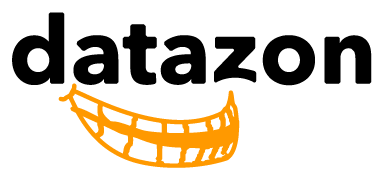

# Exploratory analysis of online retail data from Datazon

## In this notebook, we'll import the online retail database, clean it and analyse it. We'll basically prepare it in order to classify the customers as soon as they make their 1st purchase

## Importation

In [22]:
# Importation of useful libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns

import random 
import datetime as dt
import re
import pickle
import nltk, warnings
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from string import digits, punctuation


from scipy.stats import chi2_contingency

from sklearn.preprocessing import LabelEncoder, StandardScaler, Normalizer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import preprocessing, model_selection, metrics, feature_selection
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn import neighbors, linear_model, svm, tree, ensemble
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from wordcloud import WordCloud, STOPWORDS

warnings.filterwarnings("ignore")
plt.style.use('bmh')
%matplotlib inline

In [23]:
# Importing the database 

data = pd.read_excel("Online Retail.xlsx")

## 1. First steps of cleaning the data

In [24]:
data.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null datetime64[ns]
UnitPrice      541909 non-null float64
CustomerID     406829 non-null float64
Country        541909 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


Let's take a look a the missing values. 

Text(0.5,1,'Ratio of missing values per columns')

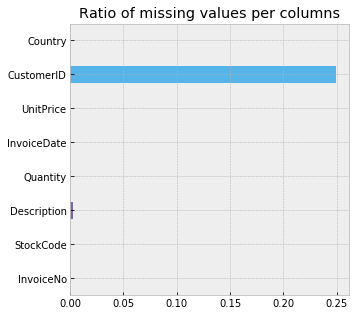

In [26]:
plt.figure(figsize=(5, 5))
data.isnull().mean(axis=0).plot.barh()
plt.title("Ratio of missing values per columns")

Let's take a closer look at the missing values

In [27]:
nan_rows = data[data.isnull().T.any().T]
nan_rows.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,2010-12-01 11:52:00,0.00,NaN,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,2010-12-01 14:32:00,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,2010-12-01 14:32:00,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,2010-12-01 14:32:00,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,2010-12-01 14:32:00,1.66,NaN,United Kingdom
1447,536544,21790,VINTAGE SNAP CARDS,9,2010-12-01 14:32:00,1.66,NaN,United Kingdom
1448,536544,21791,VINTAGE HEADS AND TAILS CARD GAME,2,2010-12-01 14:32:00,2.51,NaN,United Kingdom
1449,536544,21801,CHRISTMAS TREE DECORATION WITH BELL,10,2010-12-01 14:32:00,0.43,NaN,United Kingdom
1450,536544,21802,CHRISTMAS TREE HEART DECORATION,9,2010-12-01 14:32:00,0.43,NaN,United Kingdom
1451,536544,21803,CHRISTMAS TREE STAR DECORATION,11,2010-12-01 14:32:00,0.43,NaN,United Kingdom


Since the missing values are only in the CustomerID column and the description column, we could try to look at the InvoiceNo and see if maybe we can find the Customer ID

In [28]:
data[data['InvoiceNo']== 536414]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,2010-12-01 11:52:00,0.0,NaN,United Kingdom


In [29]:
data[data['InvoiceNo']== 536544][:5]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,2010-12-01 14:32:00,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,2010-12-01 14:32:00,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,2010-12-01 14:32:00,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,2010-12-01 14:32:00,1.66,NaN,United Kingdom
1447,536544,21790,VINTAGE SNAP CARDS,9,2010-12-01 14:32:00,1.66,NaN,United Kingdom


It appears that we can't replace the missing values and we can't keep data without the value in the customer id columns since we want to classify the customers. So I'll drop the lines with missing values on the customer ID column. 

In [30]:
data = data.dropna(subset=["CustomerID"])

Text(0.5,1,'Ratio of missing values per columns')

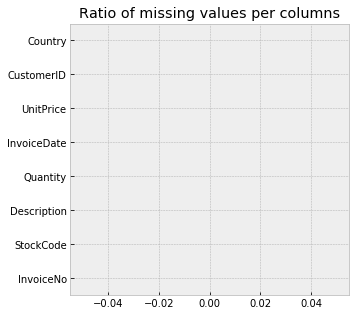

In [31]:
plt.figure(figsize=(5, 5))
data.isnull().mean(axis=0).plot.barh()
plt.title("Ratio of missing values per columns")

There are no more missing values.

I'll check the dupplicate values now and drop them.

In [32]:
print('Dupplicate entries: {}'.format(data.duplicated().sum()))
data.drop_duplicates(inplace = True)

Dupplicate entries: 5225


## 2. Exploring the variables

### 2.1 Country 

In [33]:
data.Country.nunique()

37

In [34]:
customer_country=data[['Country','CustomerID']].drop_duplicates()
customer_country.groupby(['Country'])['CustomerID'].aggregate('count').reset_index().sort_values('CustomerID', ascending=False)

,Country,CustomerID
35,United Kingdom,3950
14,Germany,95
13,France,87
30,Spain,31
3,Belgium,25
32,Switzerland,21
26,Portugal,19
18,Italy,15
12,Finland,12
1,Austria,11


More than 90% of the data is coming from UK this can be problematic for training the model but we'll keep it for now.

### 2.2 Quantity

In [35]:
data.describe()

,Quantity,UnitPrice,CustomerID
count,401604.000000,401604.000000,401604.000000
mean,12.183273,3.474064,15281.160818
std,250.283037,69.764035,1714.006089
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,13939.000000
50%,5.000000,1.950000,15145.000000
75%,12.000000,3.750000,16784.000000
max,80995.000000,38970.000000,18287.000000


In [36]:
data[(data['Quantity']<0)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
238,C536391,21980,PACK OF 12 RED RETROSPOT TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
239,C536391,21484,CHICK GREY HOT WATER BOTTLE,-12,2010-12-01 10:24:00,3.45,17548.0,United Kingdom
240,C536391,22557,PLASTERS IN TIN VINTAGE PAISLEY,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom
241,C536391,22553,PLASTERS IN TIN SKULLS,-24,2010-12-01 10:24:00,1.65,17548.0,United Kingdom
939,C536506,22960,JAM MAKING SET WITH JARS,-6,2010-12-01 12:38:00,4.25,17897.0,United Kingdom


This is very interesting since we can see various things here :
* The stock code values aren't only numerical, there are speciales values like D and M which means Discount and Manual. 
* The InvoiceNo aren't also only numerical since there is a C before the other numbers for every negative value in the quantity column, this could mean that the order was canceled.

I'll analyse the InvoiceNo to find any patterns. 

### 2.3 InvoiceNo - Cancelation Code

This part was inspired by the brilliant work of Fabien Daniel on his Notebook on customer segmentation. 

In [37]:
# Constucting a basket for later use
temp = data.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
nb_products_per_basket = temp.rename(columns = {'InvoiceDate':'Number of products'})

In [38]:
nb_products_per_basket.InvoiceNo = nb_products_per_basket.InvoiceNo.astype(str)
nb_products_per_basket['order_canceled'] = nb_products_per_basket['InvoiceNo'].apply(lambda x:int('C' in x))
len(nb_products_per_basket[nb_products_per_basket['order_canceled']==1])/len(nb_products_per_basket)*100

16.466876971608833

It appears that more than 16% of the transactions were canceled which is significant.
Let's take a look at some rows where the transaction was canceled.

In [39]:
nb_products_per_basket[nb_products_per_basket['order_canceled']==1][:5]

,CustomerID,InvoiceNo,Number of products,order_canceled
1,12346.0,C541433,1,1
23,12352.0,C545329,2,1
24,12352.0,C545330,1,1
25,12352.0,C547388,7,1
39,12359.0,C549955,2,1


In [40]:
data[data['CustomerID'] == 12346.0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346.0,United Kingdom
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346.0,United Kingdom


By looking at these results, it appears that there is a counterpart to the canceled transaction in the database. Let's see if this is always the case.

In [41]:
test = data[data['Quantity'] < 0][['CustomerID','Quantity',
                                                   'StockCode','Description','UnitPrice']]
for index, col in  test.iterrows():
    if data[(data['CustomerID'] == col[0]) & (data['Quantity'] == -col[1]) 
                & (data['Description'] == col[2])].shape[0] == 0: 
        print(test.loc[index])
        print('Our initial hypothesis is wrong')
        break

CustomerID        14527
Quantity             -1
StockCode             D
Description    Discount
UnitPrice          27.5
Name: 141, dtype: object
Our initial hypothesis is wrong


In [42]:
data[data['CustomerID'] == 14527.0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom
8963,537159,22112,CHOCOLATE HOT WATER BOTTLE,6,2010-12-05 13:17:00,4.95,14527.0,United Kingdom
8964,537159,22111,SCOTTIE DOG HOT WATER BOTTLE,1,2010-12-05 13:17:00,4.95,14527.0,United Kingdom
8965,537159,21479,WHITE SKULL HOT WATER BOTTLE,1,2010-12-05 13:17:00,3.75,14527.0,United Kingdom
8966,537159,22114,HOT WATER BOTTLE TEA AND SYMPATHY,6,2010-12-05 13:17:00,3.95,14527.0,United Kingdom
8967,537159,35598B,BLACK CHRISTMAS TREE 60CM,1,2010-12-05 13:17:00,2.95,14527.0,United Kingdom
8968,537159,22866,HAND WARMER SCOTTY DOG DESIGN,3,2010-12-05 13:17:00,2.10,14527.0,United Kingdom
8969,537159,22865,HAND WARMER OWL DESIGN,7,2010-12-05 13:17:00,2.10,14527.0,United Kingdom
8970,537159,22632,HAND WARMER RED RETROSPOT,3,2010-12-05 13:17:00,2.10,14527.0,United Kingdom
8971,537159,22684,FRENCH BLUE METAL DOOR SIGN 9,1,2010-12-05 13:17:00,1.25,14527.0,United Kingdom


It appears that when there is a discount there are no counterparts.

Let's try again but without the discount values

In [43]:
data_check = data[(data['Quantity'] < 0) & (data['Description'] != 'Discount')][
                                 ['CustomerID','Quantity','StockCode',
                                  'Description','UnitPrice']]

for index, col in  data_check.iterrows():
    if data[(data['CustomerID'] == col[0]) & (data['Quantity'] == -col[1]) 
                & (data['Description'] == col[2])].shape[0] == 0: 
        print(index, data_check.loc[index])
        print('The second hypothesis is also wrong')
        break

154 CustomerID                               15311
Quantity                                    -1
StockCode                               35004C
Description    SET OF 3 COLOURED  FLYING DUCKS
UnitPrice                                 4.65
Name: 154, dtype: object
The second hypothesis is also wrong


In [44]:
data[(data['CustomerID'] == 15311.0) & (data['Description'] == 'SET OF 3 COLOURED  FLYING DUCKS')]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom
9200,537195,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2010-12-05 13:55:00,4.65,15311.0,United Kingdom
18196,C537805,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-08 13:18:00,4.65,15311.0,United Kingdom
28630,538651,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2010-12-13 15:07:00,4.65,15311.0,United Kingdom
39381,C539640,35004C,SET OF 3 COLOURED FLYING DUCKS,-3,2010-12-20 15:27:00,4.65,15311.0,United Kingdom
44157,540157,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2011-01-05 11:41:00,4.65,15311.0,United Kingdom
59542,541293,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2011-01-17 13:39:00,4.65,15311.0,United Kingdom
78333,C542866,35004C,SET OF 3 COLOURED FLYING DUCKS,-2,2011-02-01 12:14:00,4.65,15311.0,United Kingdom


It appears that the customer can also cancel just a part of the transaction which is logical so we need to take this into account for later.

In [45]:
df_cleaned = data.copy(deep = True)
df_cleaned['QuantityCanceled'] = 0

entry_to_remove = [] ; doubtfull_entry = []

for index, col in  data.iterrows():
    if (col['Quantity'] > 0) or col['Description'] == 'Discount': continue        
    df_test = data[(data['CustomerID'] == col['CustomerID']) &
                         (data['StockCode']  == col['StockCode']) & 
                         (data['InvoiceDate'] < col['InvoiceDate']) & 
                         (data['Quantity']   > 0)].copy()
    #_________________________________
    # Cancelation WITHOUT counterpart
    if (df_test.shape[0] == 0): 
        doubtfull_entry.append(index)
    #________________________________
    # Cancelation WITH a counterpart
    elif (df_test.shape[0] == 1): 
        index_order = df_test.index[0]
        df_cleaned.loc[index_order, 'QuantityCanceled'] = -col['Quantity']
        entry_to_remove.append(index)        
    #______________________________________________________________
    # Various counterparts exist in orders: we delete the last one
    elif (df_test.shape[0] > 1): 
        df_test.sort_index(axis=0 ,ascending=False, inplace = True)        
        for ind, val in df_test.iterrows():
            if val['Quantity'] < -col['Quantity']: continue
            df_cleaned.loc[ind, 'QuantityCanceled'] = -col['Quantity']
            entry_to_remove.append(index) 
            break    

In [46]:
print("entry_to_remove: {}".format(len(entry_to_remove)))
print("doubtfull_entry: {}".format(len(doubtfull_entry)))

entry_to_remove: 7521
doubtfull_entry: 1226


In [47]:
df_cleaned.drop(entry_to_remove, axis = 0, inplace = True)
df_cleaned.drop(doubtfull_entry, axis = 0, inplace = True)
remaining_entries = df_cleaned[(df_cleaned['Quantity'] < 0) & (df_cleaned['StockCode'] != 'D')]
print("nb of entries to delete: {}".format(remaining_entries.shape[0]))
remaining_entries[:5]

nb of entries to delete: 48


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled
77598,C542742,84535B,FAIRY CAKES NOTEBOOK A6 SIZE,-94,2011-01-31 16:26:00,0.65,15358.0,United Kingdom,0
90444,C544038,22784,LANTERN CREAM GAZEBO,-4,2011-02-15 11:32:00,4.95,14659.0,United Kingdom,0
111968,C545852,22464,HANGING METAL HEART LANTERN,-5,2011-03-07 13:49:00,1.65,14048.0,United Kingdom,0
116064,C546191,47566B,TEA TIME PARTY BUNTING,-35,2011-03-10 10:57:00,0.70,16422.0,United Kingdom,0
132642,C547675,22263,FELT EGG COSY LADYBIRD,-49,2011-03-24 14:07:00,0.66,17754.0,United Kingdom,0


In [48]:
df_cleaned.drop(remaining_entries.index, axis = 0, inplace = True)

### 2.4 Stockcode

In [49]:
df_cleaned['StockCode'] = df_cleaned['StockCode'].astype(str)

In [50]:
list_special_codes = df_cleaned[df_cleaned['StockCode'].str.contains('^[a-zA-Z]+', regex=True)]['StockCode'].unique()
list_special_codes

array(['POST', 'D', 'C2', 'M', 'BANK CHARGES', 'PADS', 'DOT'],
      dtype=object)

These are specific operations which doesn't characterize our customers so I'll just drop these transactions from our databse

In [51]:
df_cleaned = df_cleaned[df_cleaned['StockCode']!= 'POST']
df_cleaned = df_cleaned[df_cleaned['StockCode']!= 'D']
df_cleaned = df_cleaned[df_cleaned['StockCode']!= 'C2']
df_cleaned = df_cleaned[df_cleaned['StockCode']!= 'M']
df_cleaned = df_cleaned[df_cleaned['StockCode']!= 'BANK CHARGES']
df_cleaned = df_cleaned[df_cleaned['StockCode']!= 'PADS']
df_cleaned = df_cleaned[df_cleaned['StockCode']!= 'DOT']

### 2.5 Outliers

In [52]:
df_cleaned.describe()

,Quantity,UnitPrice,CustomerID,QuantityCanceled
count,391183.000000,391183.000000,391183.000000,391183.000000
mean,13.179665,2.874130,15295.083503,0.626569
std,181.907403,4.284639,1710.359579,175.902239
min,1.000000,0.000000,12346.000000,0.000000
25%,2.000000,1.250000,13969.000000,0.000000
50%,6.000000,1.950000,15158.000000,0.000000
75%,12.000000,3.750000,16794.000000,0.000000
max,80995.000000,649.500000,18287.000000,80995.000000


The minimum value for the unitprice is 0, let's see why is that.

In [53]:
df_cleaned[(df_cleaned['UnitPrice'] == 0)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled
9302,537197,22841,ROUND CAKE TIN VINTAGE GREEN,1,2010-12-05 14:02:00,0.0,12647.0,Germany,0
33576,539263,22580,ADVENT CALENDAR GINGHAM SACK,4,2010-12-16 14:36:00,0.0,16560.0,United Kingdom,0
40089,539722,22423,REGENCY CAKESTAND 3 TIER,10,2010-12-21 13:45:00,0.0,14911.0,EIRE,0
47068,540372,22090,PAPER BUNTING RETROSPOT,24,2011-01-06 16:41:00,0.0,13081.0,United Kingdom,0
47070,540372,22553,PLASTERS IN TIN SKULLS,24,2011-01-06 16:41:00,0.0,13081.0,United Kingdom,0
56674,541109,22168,ORGANISER WOOD ANTIQUE WHITE,1,2011-01-13 15:10:00,0.0,15107.0,United Kingdom,0
86789,543599,84535B,FAIRY CAKES NOTEBOOK A6 SIZE,16,2011-02-10 13:08:00,0.0,17560.0,United Kingdom,0
130188,547417,22062,CERAMIC BOWL WITH LOVE HEART DESIGN,36,2011-03-23 10:25:00,0.0,13239.0,United Kingdom,0
139453,548318,22055,MINI CAKE STAND HANGING STRAWBERY,5,2011-03-30 12:45:00,0.0,13113.0,United Kingdom,0
145208,548871,22162,HEART GARLAND RUSTIC PADDED,2,2011-04-04 14:42:00,0.0,14410.0,United Kingdom,0


In [54]:
df_cleaned[(df_cleaned['StockCode'] == '22841')]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled
3925,536738,22841,ROUND CAKE TIN VINTAGE GREEN,2,2010-12-02 13:06:00,7.95,15827.0,United Kingdom,0
5111,536844,22841,ROUND CAKE TIN VINTAGE GREEN,2,2010-12-02 18:49:00,7.95,14236.0,United Kingdom,0
5328,536859,22841,ROUND CAKE TIN VINTAGE GREEN,1,2010-12-03 10:43:00,7.95,12841.0,United Kingdom,0
9302,537197,22841,ROUND CAKE TIN VINTAGE GREEN,1,2010-12-05 14:02:00,0.00,12647.0,Germany,0
9543,537207,22841,ROUND CAKE TIN VINTAGE GREEN,1,2010-12-05 15:06:00,7.95,17402.0,United Kingdom,0
9837,537219,22841,ROUND CAKE TIN VINTAGE GREEN,1,2010-12-05 15:47:00,7.95,14081.0,United Kingdom,0
16285,537646,22841,ROUND CAKE TIN VINTAGE GREEN,1,2010-12-07 15:39:00,7.95,17591.0,United Kingdom,0
18090,537794,22841,ROUND CAKE TIN VINTAGE GREEN,1,2010-12-08 13:01:00,7.95,16713.0,United Kingdom,0
24282,538347,22841,ROUND CAKE TIN VINTAGE GREEN,2,2010-12-10 14:54:00,7.95,17220.0,United Kingdom,0
36178,539439,22841,ROUND CAKE TIN VINTAGE GREEN,2,2010-12-17 15:14:00,7.95,13869.0,United Kingdom,0


I am tempted to replace the null values by the most common one but it might be a special discount or something else so I'll leave it like that.

Here let's remove the items that got completely canceled in order to harmonize the futur clusters and not have too much special values.

In [55]:
cancelation = df_cleaned[df_cleaned['Quantity'] == df_cleaned['QuantityCanceled']]

df_cleaned.drop(cancelation.index, axis = 0, inplace = True)

## 3. Feature engineering 

In [56]:
def unique_counts(data):
   for i in data.columns:
       count = data[i].nunique()
       print(i, ": ", count)
unique_counts(df_cleaned)

InvoiceNo :  18293
StockCode :  3645
Description :  3854
Quantity :  292
InvoiceDate :  17071
UnitPrice :  355
CustomerID :  4325
Country :  37
QuantityCanceled :  86


### 3.1 Total Price

In [57]:
# Total price feature

df_cleaned['TotalPrice'] = df_cleaned['UnitPrice'] * (df_cleaned['Quantity'] - df_cleaned['QuantityCanceled'])

We can now look at the countries' monetary value thanks to this feature

Text(0.5,1,'Revenue per Country')

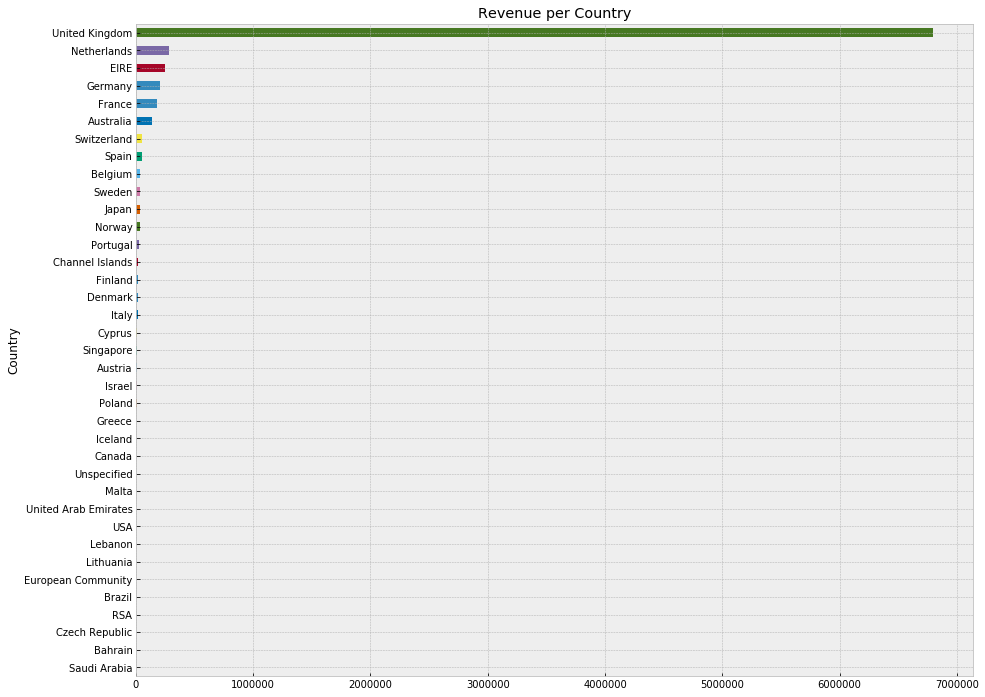

In [58]:
revenue_per_countries = df_cleaned.groupby(["Country"])["TotalPrice"].sum().sort_values()
revenue_per_countries.plot(kind='barh', figsize=(15,12))
plt.title("Revenue per Country")


Text(0.5,1,'Number of Invoices per Country')

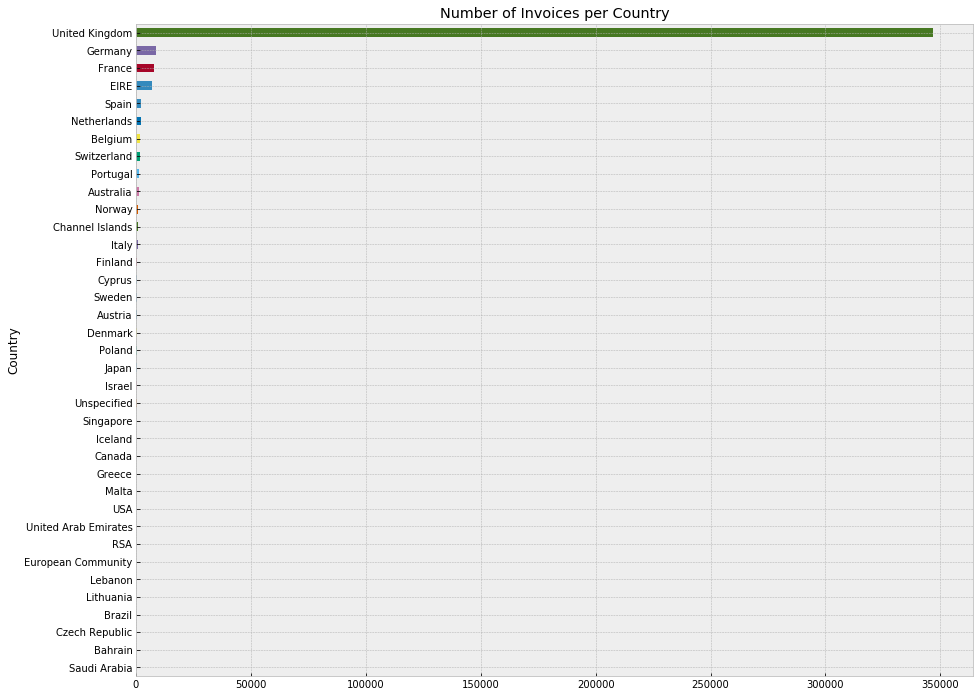

In [59]:
No_invoice_per_country = df_cleaned.groupby(["Country"])["InvoiceNo"].count().sort_values()
No_invoice_per_country.plot(kind='barh', figsize=(15,12))
plt.title("Number of Invoices per Country")

This is very interesting since we can see that Netherlands is the 2nd country in value even though it has less invoices than countries like Germany or France for example and 10 times less customers. (95, 87 and 9 for Germany, France and Netherlands respectively)

In [60]:
le = LabelEncoder()
le.fit(df_cleaned['Country'])

LabelEncoder()

In [61]:
l = [i for i in range(37)]
dict(zip(list(le.classes_), l))

{'Australia': 0,
 'Austria': 1,
 'Bahrain': 2,
 'Belgium': 3,
 'Brazil': 4,
 'Canada': 5,
 'Channel Islands': 6,
 'Cyprus': 7,
 'Czech Republic': 8,
 'Denmark': 9,
 'EIRE': 10,
 'European Community': 11,
 'Finland': 12,
 'France': 13,
 'Germany': 14,
 'Greece': 15,
 'Iceland': 16,
 'Israel': 17,
 'Italy': 18,
 'Japan': 19,
 'Lebanon': 20,
 'Lithuania': 21,
 'Malta': 22,
 'Netherlands': 23,
 'Norway': 24,
 'Poland': 25,
 'Portugal': 26,
 'RSA': 27,
 'Saudi Arabia': 28,
 'Singapore': 29,
 'Spain': 30,
 'Sweden': 31,
 'Switzerland': 32,
 'USA': 33,
 'United Arab Emirates': 34,
 'United Kingdom': 35,
 'Unspecified': 36}

In [62]:
df_cleaned['Country'] = le.transform(df_cleaned['Country'])

In [191]:
with open('labelencoder.pickle', 'wb') as g:
    pickle.dump(le, g)

In [63]:
df_cleaned.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,35,0,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,35,0,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,35,0,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,35,0,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,35,0,20.34


### 3.2 RFM Principle

I'll implement here the RFM principle to classify the customers in this database. This part is inspired by the work of Susan Li. 
RFM stands for Recency, Frequency and Monetary. It is a customer segmentation technique that uses past purchase behavior to divide customers into groups.

In [74]:
df_cleaned['InvoiceDate'].min()

Timestamp('2010-12-01 08:26:00')

In [75]:
df_cleaned['InvoiceDate'].max()

Timestamp('2011-12-09 12:50:00')

In [76]:
# I'll just fix the date to be one day after the last entry in the databse

NOW = dt.datetime(2011,12,10)
df_cleaned['InvoiceDate'] = pd.to_datetime(df_cleaned['InvoiceDate'])

In [95]:
custom_aggregation = {}
custom_aggregation["InvoiceDate"] = lambda x:x.iloc[0]
custom_aggregation["CustomerID"] = lambda x:x.iloc[0]
custom_aggregation["TotalPrice"] = "sum"


rfmTable = df_cleaned.groupby("InvoiceNo").agg(custom_aggregation)

In [96]:
rfmTable["Recency"] = NOW - rfmTable["InvoiceDate"]
rfmTable["Recency"] = pd.to_timedelta(rfmTable["Recency"]).astype("timedelta64[D]")


In [97]:
rfmTable.head(5)

,InvoiceDate,CustomerID,TotalPrice,Recency
InvoiceNo,,,,
536365,2010-12-01 08:26:00,17850.0,139.12,373.0
536366,2010-12-01 08:28:00,17850.0,22.20,373.0
536367,2010-12-01 08:34:00,13047.0,278.73,373.0
536368,2010-12-01 08:34:00,13047.0,70.05,373.0
536369,2010-12-01 08:35:00,13047.0,17.85,373.0


In [98]:
custom_aggregation = {}

custom_aggregation["Recency"] = ["min", "max"]
custom_aggregation["InvoiceDate"] = lambda x: len(x)
custom_aggregation["TotalPrice"] = "sum"

rfmTable_final = rfmTable.groupby("CustomerID").agg(custom_aggregation)

In [99]:
rfmTable_final.columns = ["min_recency", "max_recency", "frequency", "monetary_value"]

In [100]:
rfmTable_final.head(5)

,min_recency,max_recency,frequency,monetary_value
CustomerID,,,,
12347.0,2.0,367.0,7,4310.00
12348.0,75.0,358.0,4,1437.24
12349.0,18.0,18.0,1,1457.55
12350.0,310.0,310.0,1,294.40
12352.0,36.0,296.0,6,1265.41


In [102]:
first_customer = df_cleaned[df_cleaned['CustomerID']==12747.0]
first_customer

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,TotalPrice
9754,537215,85124C,GREEN JUICY FRUIT PHOTO FRAME,12,2010-12-05 15:38:00,2.55,12747.0,35,0,30.60
9755,537215,85124B,BLUE JUICY FRUIT PHOTO FRAME,6,2010-12-05 15:38:00,2.55,12747.0,35,0,15.30
9756,537215,84879,ASSORTED COLOUR BIRD ORNAMENT,16,2010-12-05 15:38:00,1.69,12747.0,35,0,27.04
9757,537215,85062,PEARL CRYSTAL PUMPKIN T-LIGHT HLDR,24,2010-12-05 15:38:00,1.65,12747.0,35,0,39.60
9758,537215,85064,CREAM SWEETHEART LETTER RACK,6,2010-12-05 15:38:00,5.45,12747.0,35,0,32.70
9759,537215,82484,WOOD BLACK BOARD ANT WHITE FINISH,36,2010-12-05 15:38:00,5.55,12747.0,35,0,199.80
9760,537215,21136,PAINTED METAL PEARS ASSORTED,8,2010-12-05 15:38:00,1.69,12747.0,35,0,13.52
27390,538537,22795,SWEETHEART RECIPE BOOK STAND,16,2010-12-13 10:41:00,5.95,12747.0,35,0,95.20
27391,538537,48138,DOORMAT UNION FLAG,2,2010-12-13 10:41:00,7.95,12747.0,35,0,15.90
27392,538537,82494L,WOODEN FRAME ANTIQUE WHITE,24,2010-12-13 10:41:00,2.55,12747.0,35,0,61.20


The first customer has shopped a lot.

In [103]:
quantiles = rfmTable_final.quantile(q=[0.25,0.5,0.75])
quantiles = quantiles.to_dict()

In [104]:
segmented_rfm = rfmTable_final

In [105]:
def RScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
    
def FMScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1

Here we'll apply a score on each feature of RFM

In [106]:
segmented_rfm['r_quartile'] = segmented_rfm['min_recency'].apply(RScore, args=('min_recency',quantiles,))
segmented_rfm['f_quartile'] = segmented_rfm['frequency'].apply(FMScore, args=('frequency',quantiles,))
segmented_rfm['m_quartile'] = segmented_rfm['monetary_value'].apply(FMScore, args=('monetary_value',quantiles,))
segmented_rfm.head()

,min_recency,max_recency,frequency,monetary_value,r_quartile,f_quartile,m_quartile
CustomerID,,,,,,,
12347.0,2.0,367.0,7,4310.00,1,1,1
12348.0,75.0,358.0,4,1437.24,3,2,2
12349.0,18.0,18.0,1,1457.55,2,4,2
12350.0,310.0,310.0,1,294.40,4,4,4
12352.0,36.0,296.0,6,1265.41,2,1,2


Finally we'll set a score for each customer in the database. 

In [107]:
segmented_rfm['RFMScore'] = segmented_rfm.r_quartile.map(str) + segmented_rfm.f_quartile.map(str) + segmented_rfm.m_quartile.map(str)
segmented_rfm.head()

,min_recency,max_recency,frequency,monetary_value,r_quartile,f_quartile,m_quartile,RFMScore
CustomerID,,,,,,,,
12347.0,2.0,367.0,7,4310.00,1,1,1,111
12348.0,75.0,358.0,4,1437.24,3,2,2,322
12349.0,18.0,18.0,1,1457.55,2,4,2,242
12350.0,310.0,310.0,1,294.40,4,4,4,444
12352.0,36.0,296.0,6,1265.41,2,1,2,212


In [108]:
segmented_rfm[segmented_rfm['RFMScore']=='111'].sort_values('monetary_value', ascending=False)

,min_recency,max_recency,frequency,monetary_value,r_quartile,f_quartile,m_quartile,RFMScore
CustomerID,,,,,,,,
14646.0,1.0,354.0,73,278742.02,1,1,1,111
18102.0,0.0,367.0,60,259657.30,1,1,1,111
17450.0,8.0,367.0,46,193417.63,1,1,1,111
14911.0,1.0,373.0,196,129075.91,1,1,1,111
14156.0,9.0,371.0,54,113720.20,1,1,1,111
17511.0,2.0,373.0,30,88353.14,1,1,1,111
16684.0,4.0,358.0,28,65920.12,1,1,1,111
13694.0,3.0,373.0,50,63067.14,1,1,1,111
15311.0,0.0,373.0,91,59606.58,1,1,1,111


Here we have an example of customers with a score of 111 which means that they are classified as our best customers.

In [109]:
segmented_rfm.head(5)

,min_recency,max_recency,frequency,monetary_value,r_quartile,f_quartile,m_quartile,RFMScore
CustomerID,,,,,,,,
12347.0,2.0,367.0,7,4310.00,1,1,1,111
12348.0,75.0,358.0,4,1437.24,3,2,2,322
12349.0,18.0,18.0,1,1457.55,2,4,2,242
12350.0,310.0,310.0,1,294.40,4,4,4,444
12352.0,36.0,296.0,6,1265.41,2,1,2,212


In [110]:
segmented_rfm = segmented_rfm.reset_index()

In [111]:
segmented_rfm.head(5)

,CustomerID,min_recency,max_recency,frequency,monetary_value,r_quartile,f_quartile,m_quartile,RFMScore
0,12347.0,2.0,367.0,7,4310.00,1,1,1,111
1,12348.0,75.0,358.0,4,1437.24,3,2,2,322
2,12349.0,18.0,18.0,1,1457.55,2,4,2,242
3,12350.0,310.0,310.0,1,294.40,4,4,4,444
4,12352.0,36.0,296.0,6,1265.41,2,1,2,212


In [112]:
df_cleaned = pd.merge(df_cleaned,segmented_rfm, on='CustomerID')

In [113]:
df_cleaned.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country', 'QuantityCanceled', 'TotalPrice',
       'min_recency', 'max_recency', 'frequency', 'monetary_value',
       'r_quartile', 'f_quartile', 'm_quartile', 'RFMScore'],
      dtype='object')

We don't need the quartiles anymore, let's drop them.

In [114]:
df_cleaned = df_cleaned.drop(columns=['r_quartile', 'f_quartile', 'm_quartile'])

==> Score's definition

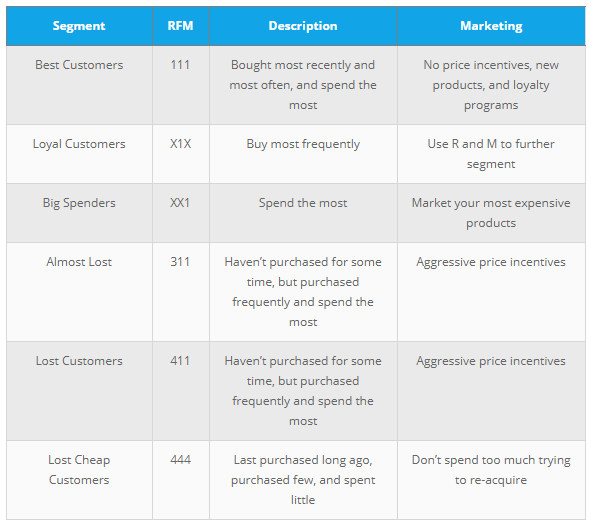

### 3.3 Time features

I'll now create some time features, although I might not use them. It could be interesting to see if there are any paterns due to seasonality. 

In [115]:
df_cleaned['Month'] = df_cleaned["InvoiceDate"].map(lambda x: x.month)

In [116]:
df_cleaned['Month'].value_counts()

11    62736
10    48223
12    42339
9     39238
5     27766
6     26601
8     26546
3     26484
7     26260
4     22211
1     20719
2     19517
Name: Month, dtype: int64

In [117]:
df_cleaned['Weekday'] = df_cleaned["InvoiceDate"].map(lambda x: x.weekday())
df_cleaned['Day'] = df_cleaned["InvoiceDate"].map(lambda x: x.day)
df_cleaned['Hour'] = df_cleaned["InvoiceDate"].map(lambda x: x.hour)

In [118]:
df_cleaned.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,TotalPrice,min_recency,max_recency,frequency,monetary_value,RFMScore,Month,Weekday,Day,Hour
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,35,0,15.30,372.0,373.0,34,5322.84,411,12,2,1,8
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,35,0,20.34,372.0,373.0,34,5322.84,411,12,2,1,8
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,35,0,22.00,372.0,373.0,34,5322.84,411,12,2,1,8
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,35,0,20.34,372.0,373.0,34,5322.84,411,12,2,1,8
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,35,0,20.34,372.0,373.0,34,5322.84,411,12,2,1,8


### 3.4 Product categories

In [119]:
X = df_cleaned["Description"].unique()

stemmer = nltk.stem.porter.PorterStemmer()
stopword = nltk.corpus.stopwords.words('english')

def stem_and_filter(doc):
    tokens = [stemmer.stem(w) for w in analyzer(doc)]
    return [token for token in tokens if token.isalpha()]

analyzer = TfidfVectorizer().build_analyzer()
CV = TfidfVectorizer(lowercase=True, stop_words="english", analyzer=stem_and_filter, min_df=0.00, max_df=0.3)  # we remove words if it appears in more than 30 % of the corpus (not found stopwords like Box, Christmas and so on)
TF_IDF_matrix = CV.fit_transform(X)
print("TF_IDF_matrix :", TF_IDF_matrix.shape, "of", TF_IDF_matrix.dtype)

TF_matrix : (3854, 1693) of int64
TF_IDF_matrix : (3854, 1693) of float64


In [120]:
svd = TruncatedSVD(n_components = 100)
normalizer = Normalizer(copy=False)

TF_embedded = svd.fit_transform(TF_matrix)
TF_embedded = normalizer.fit_transform(TF_embedded)
print("TF_embedded :", TF_embedded.shape, "of", TF_embedded.dtype)

TF_IDF_embedded = svd.fit_transform(TF_IDF_matrix)
TF_IDF_embedded = normalizer.fit_transform(TF_IDF_embedded)
print("TF_IDF_embedded :", TF_IDF_embedded.shape, "of", TF_IDF_embedded.dtype)

TF_embedded : (3854, 100) of float64
TF_IDF_embedded : (3854, 100) of float64


In [121]:
score_tf = []
score_tfidf = []

x = list(range(5, 155, 10))

for n_clusters in x:
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=10)
    kmeans.fit(TF_embedded)
    clusters = kmeans.predict(TF_embedded)
    silhouette_avg = silhouette_score(TF_embedded, clusters)

    rep = np.histogram(clusters, bins = n_clusters-1)[0]
    score_tf.append(silhouette_avg)

for n_clusters in x:
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=10)
    kmeans.fit(TF_IDF_embedded)
    clusters = kmeans.predict(TF_IDF_embedded)
    silhouette_avg = silhouette_score(TF_IDF_embedded, clusters)

    rep = np.histogram(clusters, bins = n_clusters-1)[0]
    score_tfidf.append(silhouette_avg)

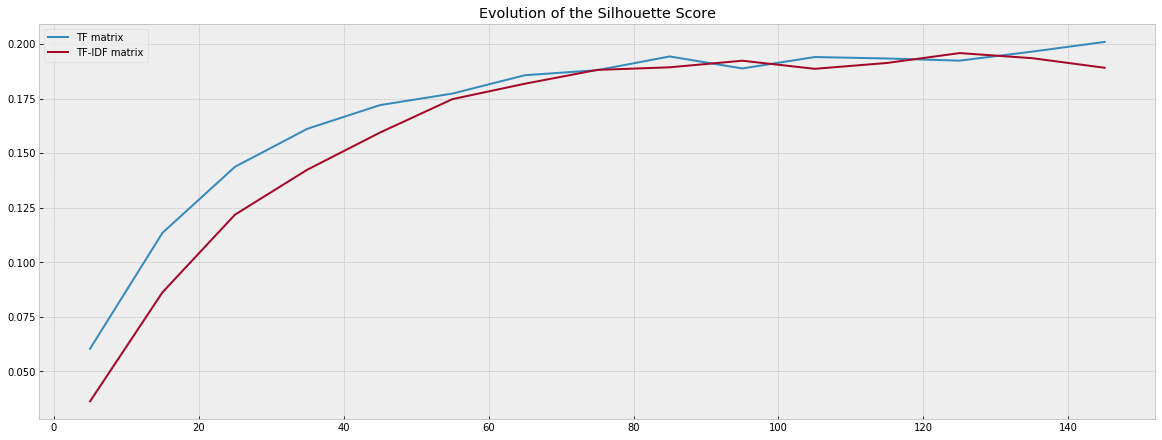

In [122]:
plt.figure(figsize=(20,16))

plt.subplot(2, 1, 1)
plt.plot(x, score_tf, label="TF matrix")
plt.plot(x, score_tfidf, label="TF-IDF matrix")
plt.title("Evolution of the Silhouette Score")
plt.legend()

The highest value for the silhouette score is when there are 135 clusters. So we'll chose this value.

Text(0.5,1,'ACP with 135 clusters')

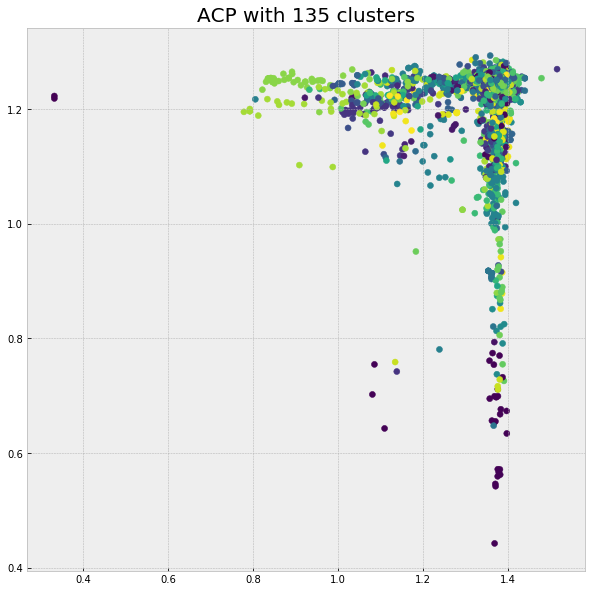

In [123]:
n_clusters = 135

kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30, random_state=0)
proj = kmeans.fit_transform(TF_IDF_embedded)
clusters = kmeans.predict(TF_IDF_embedded)
plt.figure(figsize=(10,10))
plt.scatter(proj[:,0], proj[:,1], c=clusters)
plt.title("ACP with 135 clusters", fontsize="20")

Text(0.5,1,'Visualization of the clustering with TSNE')

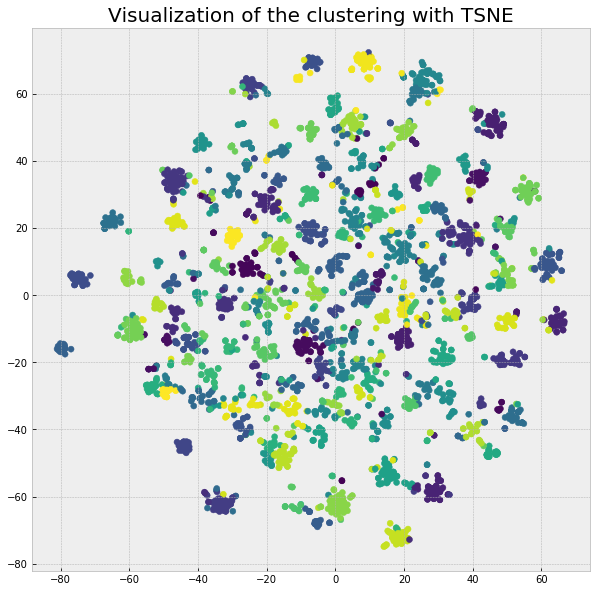

In [124]:
tsne = TSNE(n_components=2)
proj = tsne.fit_transform(TF_IDF_embedded)

plt.figure(figsize=(10,10))
plt.scatter(proj[:,0], proj[:,1], c=clusters)
plt.title("Visualization of the clustering with TSNE", fontsize="20")

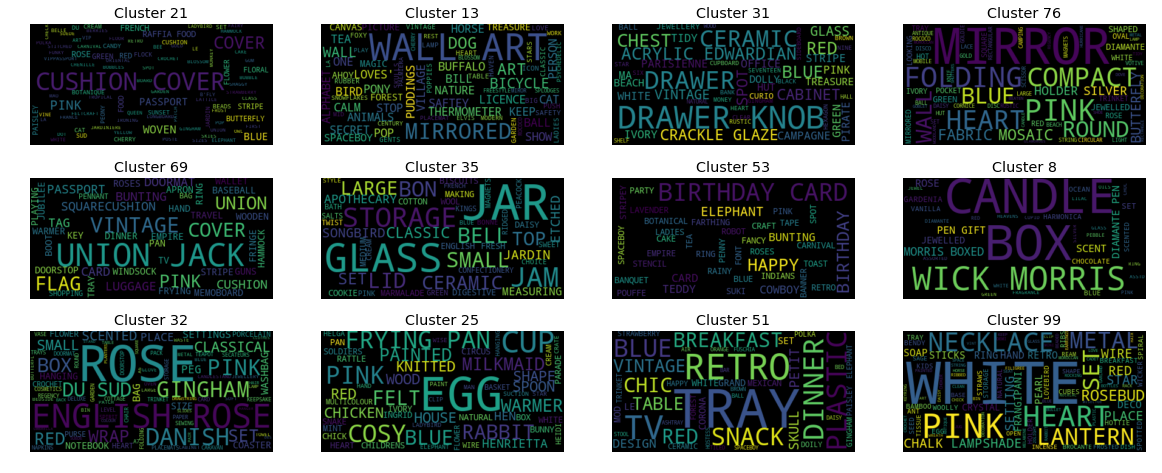

In [125]:
plt.figure(figsize=(20,8))
wc = WordCloud()

for num, cluster in enumerate(random.sample(range(100), 12)) :
    plt.subplot(3, 4, num+1)
    wc.generate(" ".join(X[np.where(clusters==cluster)]))
    plt.imshow(wc, interpolation='bilinear')
    plt.title("Cluster {}".format(cluster))
    plt.axis("off")
plt.figure()

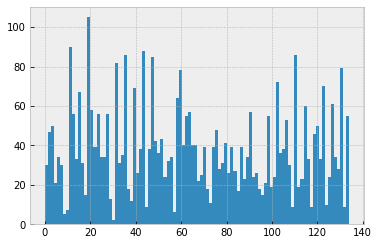

In [126]:
pd.Series(clusters).hist(bins=100)

In [127]:
dict_article_to_cluster = {article : cluster for article, cluster in zip(X, clusters)}

In [192]:
with open('product_clusters.pickle', 'wb') as h:
    pickle.dump(dict_article_to_cluster, h)

## 4. Create customer categories

### 4.1 Intermediate dataset grouped by invoices

In [128]:
cluster = df_cleaned['Description'].apply(lambda x : dict_article_to_cluster[x])
df2 = pd.get_dummies(cluster, prefix="Cluster").mul(df_cleaned["TotalPrice"], 0)
df2 = pd.concat([df_cleaned['InvoiceNo'], df2], axis=1)
df2_grouped = df2.groupby('InvoiceNo').sum()

In [129]:
custom_aggregation = {}
custom_aggregation["TotalPrice"] = lambda x:x.iloc[0]
custom_aggregation["min_recency"] = lambda x:x.iloc[0]
custom_aggregation["max_recency"] = lambda x:x.iloc[0]
custom_aggregation["frequency"] = lambda x:x.iloc[0]
custom_aggregation["monetary_value"] = lambda x:x.iloc[0]
custom_aggregation["CustomerID"] = lambda x:x.iloc[0]
custom_aggregation["Quantity"] = "sum"
custom_aggregation["Country"] = lambda x:x.iloc[0]


df_grouped = df_cleaned.groupby("InvoiceNo").agg(custom_aggregation)

### 4.2 Final Dataset per customer

In [130]:
df2_grouped_final = pd.concat([df_grouped['CustomerID'], df2_grouped], axis=1).set_index("CustomerID").groupby("CustomerID").sum()
df2_grouped_final = df2_grouped_final.div(df2_grouped_final.sum(axis=1), axis=0)
df2_grouped_final = df2_grouped_final.fillna(0)

In [131]:
custom_aggregation = {}
custom_aggregation["TotalPrice"] = ['min','max','mean']
custom_aggregation["min_recency"] = lambda x:x.iloc[0]
custom_aggregation["max_recency"] = lambda x:x.iloc[0]
custom_aggregation["frequency"] = lambda x:x.iloc[0]
custom_aggregation["monetary_value"] = lambda x:x.iloc[0]
custom_aggregation["Quantity"] = "sum"
custom_aggregation["Country"] = lambda x:x.iloc[0]

df_grouped_final = df_grouped.groupby("CustomerID").agg(custom_aggregation)

In [132]:
df_grouped_final.head(5)

TotalPrice                   min_recency max_recency frequency  \
                  min    max       mean    <lambda>    <lambda>  <lambda>   
CustomerID                                                                  
12347.0          13.2   45.0  23.308571         2.0       367.0         7   
12348.0          39.6  150.0  82.840000        75.0       358.0         4   
12349.0          15.0   15.0  15.000000        18.0        18.0         1   
12350.0          25.2   25.2  25.200000       310.0       310.0         1   
12352.0           9.9   35.7  19.650000        36.0       296.0         6   

           monetary_value Quantity  Country  
                 <lambda>      sum <lambda>  
CustomerID                                   
12347.0           4310.00     2458       16  
12348.0           1437.24     2332       12  
12349.0           1457.55      630       18  
12350.0            294.40      196       24  
12352.0           1265.41      463       24

In [133]:
df_grouped_final.columns = ["min", "max", "mean", "min_recency", "max_recency", "frequency", "monetary_value", "quantity", "country"]

In [134]:
df_grouped_final.head(5)

,min,max,mean,min_recency,max_recency,frequency,monetary_value,quantity,country
CustomerID,,,,,,,,,
12347.0,13.2,45.0,23.308571,2.0,367.0,7,4310.00,2458,16
12348.0,39.6,150.0,82.840000,75.0,358.0,4,1437.24,2332,12
12349.0,15.0,15.0,15.000000,18.0,18.0,1,1457.55,630,18
12350.0,25.2,25.2,25.200000,310.0,310.0,1,294.40,196,24
12352.0,9.9,35.7,19.650000,36.0,296.0,6,1265.41,463,24


In [135]:
df2_grouped_final.head(5)

,Cluster_0,Cluster_1,Cluster_2,Cluster_3,Cluster_4,Cluster_5,Cluster_6,Cluster_7,Cluster_8,Cluster_9,...,Cluster_125,Cluster_126,Cluster_127,Cluster_128,Cluster_129,Cluster_130,Cluster_131,Cluster_132,Cluster_133,Cluster_134
CustomerID,,,,,,,,,,,,,,,,,,,,,
12347.0,0.0,0.000000,0.006032,0.0,0.010858,0.0,0.000000,0.0,0.000000,0.007796,...,0.0,0.026729,0.0,0.000000,0.0,0.042877,0.000000,0.007494,0.046775,0.0
12348.0,0.0,0.121065,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.204559,0.159806,0.000000,0.000000,0.0
12349.0,0.0,0.005351,0.000000,0.0,0.000000,0.0,0.043772,0.0,0.000000,0.000000,...,0.0,0.004556,0.0,0.044458,0.0,0.004556,0.000000,0.000000,0.000000,0.0
12350.0,0.0,0.000000,0.060122,0.0,0.000000,0.0,0.000000,0.0,0.050951,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.050951,0.000000,0.0
12352.0,0.0,0.000000,0.011656,0.0,0.000000,0.0,0.011735,0.0,0.011854,0.000000,...,0.0,0.000000,0.0,0.028923,0.0,0.039355,0.000000,0.000000,0.000000,0.0


### 4.3 Clustering customers

In [136]:
X1 = df_grouped_final.as_matrix()
X2 = df2_grouped_final.as_matrix()

scaler = StandardScaler()
X1 = scaler.fit_transform(X1)
X_final_std_scale = np.concatenate((X1, X2), axis=1)

In [138]:
x = list(range(2, 12))
y_std = []
for n_clusters in x:
    print("n_clusters =", n_clusters)
    
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=10)
    kmeans.fit(X_final_std_scale)
    clusters = kmeans.predict(X_final_std_scale)
    silhouette_avg = silhouette_score(X_final_std_scale, clusters)
    y_std.append(silhouette_avg)
    print("The average silhouette_score is :", silhouette_avg, "with Std Scaling")

n_clusters = 2
The average silhouette_score is : 0.889460896914366 with Std Scaling
n_clusters = 3
The average silhouette_score is : 0.25914983635196154 with Std Scaling
n_clusters = 4
The average silhouette_score is : 0.25563914383635644 with Std Scaling
n_clusters = 5
The average silhouette_score is : 0.30147570547115854 with Std Scaling
n_clusters = 6
The average silhouette_score is : 0.39171930961700674 with Std Scaling
n_clusters = 7
The average silhouette_score is : 0.4008460647568816 with Std Scaling
n_clusters = 8
The average silhouette_score is : 0.40861605675164064 with Std Scaling
n_clusters = 9
The average silhouette_score is : 0.4051385508632932 with Std Scaling
n_clusters = 10
The average silhouette_score is : 0.4075487623852833 with Std Scaling
n_clusters = 11
The average silhouette_score is : 0.407191923404397 with Std Scaling


We want to have at least 5, 6 clusters so we won't take 2 or 3 clusters even though they have the highest silhouette scores, 8 clusters would fit the best here. 

In [203]:
kmeans = KMeans(init='k-means++', n_clusters = 8, n_init=30, random_state=0)  # random state just to be able to provide cluster number durint analysis
kmeans.fit(X_final_std_scale)
clusters = kmeans.predict(X_final_std_scale)

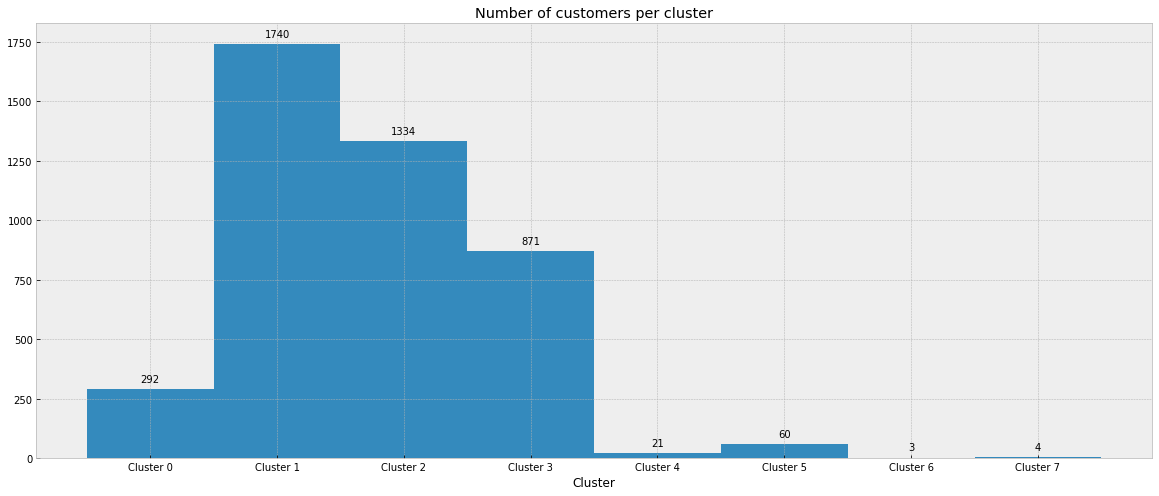

In [204]:
plt.figure(figsize = (20,8))
n, bins, patches = plt.hist(clusters, bins=8)
plt.xlabel("Cluster")
plt.title("Number of customers per cluster")
plt.xticks([rect.get_x()+ rect.get_width() / 2 for rect in patches], ["Cluster {}".format(x) for x in range(8)])

for rect in patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2

    space = 5
    va = 'bottom'
    label = str(int(y_value))
    
    plt.annotate(
        label,                      
        (x_value, y_value),         
        xytext=(0, space),          
        textcoords="offset points", 
        ha='center',                
        va=va)

In [141]:
df_grouped_final["cluster"] = clusters

In [142]:
final_dataset = pd.concat([df_grouped_final, df2_grouped_final], axis = 1)
final_dataset.head()

,min,max,mean,min_recency,max_recency,frequency,monetary_value,quantity,country,cluster,...,Cluster_125,Cluster_126,Cluster_127,Cluster_128,Cluster_129,Cluster_130,Cluster_131,Cluster_132,Cluster_133,Cluster_134
CustomerID,,,,,,,,,,,,,,,,,,,,,
12347.0,13.2,45.0,23.308571,2.0,367.0,7,4310.00,2458,16,3,...,0.0,0.026729,0.0,0.000000,0.0,0.042877,0.000000,0.007494,0.046775,0.0
12348.0,39.6,150.0,82.840000,75.0,358.0,4,1437.24,2332,12,3,...,0.0,0.000000,0.0,0.000000,0.0,0.204559,0.159806,0.000000,0.000000,0.0
12349.0,15.0,15.0,15.000000,18.0,18.0,1,1457.55,630,18,3,...,0.0,0.004556,0.0,0.044458,0.0,0.004556,0.000000,0.000000,0.000000,0.0
12350.0,25.2,25.2,25.200000,310.0,310.0,1,294.40,196,24,0,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.050951,0.000000,0.0
12352.0,9.9,35.7,19.650000,36.0,296.0,6,1265.41,463,24,1,...,0.0,0.000000,0.0,0.028923,0.0,0.039355,0.000000,0.000000,0.000000,0.0


In [538]:
final_dataset_V2 = final_dataset.reset_index()

In [539]:
final_dataset_V2.to_csv("final_dataset_V2.csv",index=False)

In [541]:
with open('df_cleaned.pickle', 'wb') as f:
    pickle.dump(df_cleaned, f)

In [209]:
final_dataset = pd.read_csv("final_dataset_V2.csv")

In [216]:
pickel_in  = open('df_cleaned.pickle', 'rb')
df_cleaned = pickle.load(pickel_in)

## 5. Interpreting the clusters

Text(0.5,1,'Visualization of the clustering with TSNE')

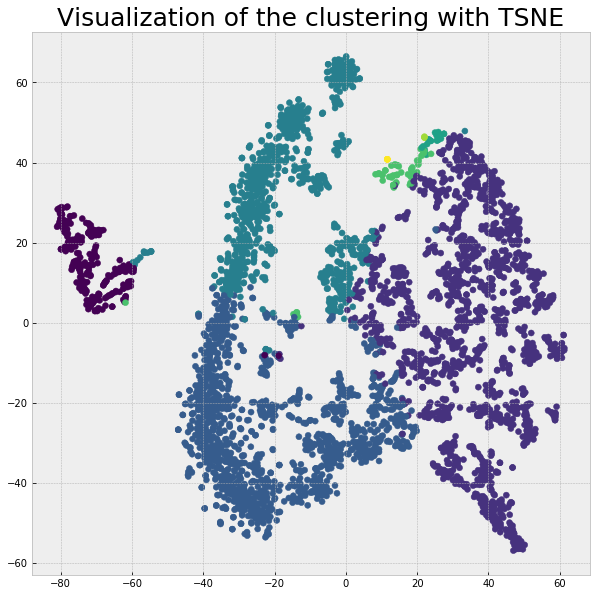

In [194]:
tsne = TSNE(n_components=2)
proj = tsne.fit_transform(X_final_std_scale)

plt.figure(figsize=(10,10))
plt.scatter(proj[:,0], proj[:,1], c=clusters)
plt.title("Visualization of the clustering with TSNE", fontsize="25")

Graphically the clusters are distinctive enough.

Let's take a closer look at the clusters that contain few customers

### Cluster 2

In [211]:
final_dataset[final_dataset['cluster']==2]

,CustomerID,min,max,mean,min_recency,max_recency,frequency,monetary_value,quantity,country,...,Cluster_125,Cluster_126,Cluster_127,Cluster_128,Cluster_129,Cluster_130,Cluster_131,Cluster_132,Cluster_133,Cluster_134
1683,14646.0,0.00,4992.00,258.014521,1.0,354.0,73,278742.02,197132,23,...,0.000372,0.018328,0.00639,0.000011,0.001337,0.02608,0.01243,0.001509,0.003821,0.0
3718,17450.0,34.56,3160.08,581.934130,8.0,367.0,46,193417.63,69973,35,...,0.000000,0.000000,0.00000,0.020827,0.000000,0.00000,0.00000,0.000000,0.000827,0.0
4189,18102.0,4.80,3285.00,700.893333,0.0,367.0,60,259657.30,64124,35,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.00000,0.000000,0.024241,0.0


In [226]:
final_dataset[final_dataset['cluster']==2].mean()

CustomerID         16732.666667
min                   13.120000
max                 3812.360000
mean                 513.613995
min_recency            3.000000
max_recency          362.666667
frequency             59.666667
monetary_value    243938.983333
quantity          110409.666667
country               31.000000
cluster                2.000000
Cluster_0              0.000431
Cluster_1              0.003275
Cluster_2              0.003134
Cluster_3              0.000000
Cluster_4              0.000405
Cluster_5              0.000000
Cluster_6              0.014502
Cluster_7              0.000000
Cluster_8              0.000036
Cluster_9              0.000364
Cluster_10             0.003697
Cluster_11             0.006578
Cluster_12             0.000221
Cluster_13             0.034527
Cluster_14             0.006617
Cluster_15             0.043486
Cluster_16             0.002219
Cluster_17             0.020928
Cluster_18             0.021085
                      ...      
Cluster_

In [146]:
df_cleaned[df_cleaned['CustomerID']==14646.0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,TotalPrice,min_recency,max_recency,frequency,monetary_value,RFMScore,Month,Weekday,Day,Hour
160565,539491,21981,PACK OF 12 WOODLAND TISSUES,12,2010-12-20 10:09:00,0.29,14646.0,23,0,3.48,1.0,354.0,73,278742.02,111,12,0,20,10
160566,539491,21986,PACK OF 12 PINK POLKADOT TISSUES,12,2010-12-20 10:09:00,0.29,14646.0,23,0,3.48,1.0,354.0,73,278742.02,111,12,0,20,10
160567,539491,22720,SET OF 3 CAKE TINS PANTRY DESIGN,2,2010-12-20 10:09:00,4.95,14646.0,23,0,9.90,1.0,354.0,73,278742.02,111,12,0,20,10
160568,539491,21931,JUMBO STORAGE BAG SUKI,1,2010-12-20 10:09:00,1.95,14646.0,23,0,1.95,1.0,354.0,73,278742.02,111,12,0,20,10
160569,539491,22613,PACK OF 20 SPACEBOY NAPKINS,2,2010-12-20 10:09:00,0.85,14646.0,23,0,1.70,1.0,354.0,73,278742.02,111,12,0,20,10
160570,539491,20751,FUNKY WASHING UP GLOVES ASSORTED,1,2010-12-20 10:09:00,2.10,14646.0,23,0,2.10,1.0,354.0,73,278742.02,111,12,0,20,10
160571,539491,21246,RED RETROSPOT BIG BOWL,2,2010-12-20 10:09:00,4.95,14646.0,23,0,9.90,1.0,354.0,73,278742.02,111,12,0,20,10
160572,539491,22960,JAM MAKING SET WITH JARS,1,2010-12-20 10:09:00,4.25,14646.0,23,0,4.25,1.0,354.0,73,278742.02,111,12,0,20,10
160573,539491,22355,CHARLOTTE BAG SUKI DESIGN,2,2010-12-20 10:09:00,0.85,14646.0,23,0,1.70,1.0,354.0,73,278742.02,111,12,0,20,10
160574,539491,21123,SET/10 IVORY POLKADOT PARTY CANDLES,2,2010-12-20 10:09:00,1.25,14646.0,23,0,2.50,1.0,354.0,73,278742.02,111,12,0,20,10


In [147]:
df_cleaned[df_cleaned['CustomerID']==17450.0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,TotalPrice,min_recency,max_recency,frequency,monetary_value,RFMScore,Month,Weekday,Day,Hour
86372,537448,21756,BATH BUILDING BLOCK WORD,6,2010-12-07 09:23:00,6.60,17450.0,35,0,39.60,8.0,367.0,46,193417.63,111,12,1,7,9
86373,537456,22469,HEART OF WICKER SMALL,402,2010-12-07 09:43:00,1.93,17450.0,35,0,775.86,8.0,367.0,46,193417.63,111,12,1,7,9
86374,537456,22470,HEART OF WICKER LARGE,378,2010-12-07 09:43:00,3.21,17450.0,35,0,1213.38,8.0,367.0,46,193417.63,111,12,1,7,9
86375,540689,21733,RED HANGING HEART T-LIGHT HOLDER,860,2011-01-11 08:43:00,3.24,17450.0,35,0,2786.40,8.0,367.0,46,193417.63,111,1,1,11,8
86376,540689,85123A,WHITE HANGING HEART T-LIGHT HOLDER,1010,2011-01-11 08:43:00,3.24,17450.0,35,0,3272.40,8.0,367.0,46,193417.63,111,1,1,11,8
86377,540689,22469,HEART OF WICKER SMALL,1356,2011-01-11 08:43:00,1.93,17450.0,35,0,2617.08,8.0,367.0,46,193417.63,111,1,1,11,8
86378,540689,22470,HEART OF WICKER LARGE,1284,2011-01-11 08:43:00,3.21,17450.0,35,0,4121.64,8.0,367.0,46,193417.63,111,1,1,11,8
86379,540691,22889,NUMBER TILE VINTAGE FONT No,24,2011-01-11 08:50:00,2.17,17450.0,35,0,52.08,8.0,367.0,46,193417.63,111,1,1,11,8
86380,540691,22887,NUMBER TILE VINTAGE FONT 8,16,2011-01-11 08:50:00,2.17,17450.0,35,0,34.72,8.0,367.0,46,193417.63,111,1,1,11,8
86381,540691,22886,NUMBER TILE VINTAGE FONT 7,16,2011-01-11 08:50:00,2.17,17450.0,35,0,34.72,8.0,367.0,46,193417.63,111,1,1,11,8


In [148]:
df_cleaned[df_cleaned['CustomerID']==18102.0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,TotalPrice,min_recency,max_recency,frequency,monetary_value,RFMScore,Month,Weekday,Day,Hour
93927,537657,82484,WOOD BLACK BOARD ANT WHITE FINISH,408,2010-12-07 16:42:00,4.78,18102.0,35,0,1950.24,0.0,367.0,60,259657.3,111,12,1,7,16
93928,537657,22830,UTILTY CABINET WITH HOOKS,30,2010-12-07 16:42:00,19.84,18102.0,35,0,595.20,0.0,367.0,60,259657.3,111,12,1,7,16
93929,537657,22189,CREAM HEART CARD HOLDER,972,2010-12-07 16:42:00,2.31,18102.0,35,0,2245.32,0.0,367.0,60,259657.3,111,12,1,7,16
93930,537657,22188,BLACK HEART CARD HOLDER,972,2010-12-07 16:42:00,2.31,18102.0,35,0,2245.32,0.0,367.0,60,259657.3,111,12,1,7,16
93931,537657,21623,VINTAGE UNION JACK MEMOBOARD,408,2010-12-07 16:42:00,6.38,18102.0,35,0,2603.04,0.0,367.0,60,259657.3,111,12,1,7,16
93932,537658,82484,WOOD BLACK BOARD ANT WHITE FINISH,48,2010-12-07 16:43:00,4.78,18102.0,35,0,229.44,0.0,367.0,60,259657.3,111,12,1,7,16
93933,537658,22189,CREAM HEART CARD HOLDER,36,2010-12-07 16:43:00,2.31,18102.0,35,0,83.16,0.0,367.0,60,259657.3,111,12,1,7,16
93934,537658,22188,BLACK HEART CARD HOLDER,36,2010-12-07 16:43:00,2.31,18102.0,35,0,83.16,0.0,367.0,60,259657.3,111,12,1,7,16
93935,537659,22765,NEWSPAPER STAND,23,2010-12-07 16:43:00,9.89,18102.0,35,0,227.47,0.0,367.0,60,259657.3,111,12,1,7,16
93936,537659,22507,MEMO BOARD RETROSPOT DESIGN,208,2010-12-07 16:43:00,3.86,18102.0,35,0,802.88,0.0,367.0,60,259657.3,111,12,1,7,16


In [224]:
cust2 = final_dataset[final_dataset['cluster']==2]['CustomerID']
cust2

1683    14646.0
3718    17450.0
4189    18102.0
Name: CustomerID, dtype: float64

In [246]:
cluster2 = df_cleaned.loc[df_cleaned['CustomerID'].isin(cust2)]
cluster2[['Quantity', 'UnitPrice', 'QuantityCanceled', 'TotalPrice', 'frequency', 'min_recency', 'monetary_value']].mean()

Quantity               117.083422
UnitPrice                2.830180
QuantityCanceled         0.069282
TotalPrice             258.683970
frequency               67.812655
min_recency              1.679039
monetary_value      265700.482580
dtype: float64

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,TotalPrice,monetary_value,nb_visit,min_recency,max_recency,frequency,RFMScore,Month,Weekday,Day,Hour
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,35,0,15.30,5322.84,34,372.0,373.0,0.029412,431,12,2,1,8
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,35,0,20.34,5322.84,34,372.0,373.0,0.029412,431,12,2,1,8
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,35,0,22.00,5322.84,34,372.0,373.0,0.029412,431,12,2,1,8
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,35,0,20.34,5322.84,34,372.0,373.0,0.029412,431,12,2,1,8
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,35,0,20.34,5322.84,34,372.0,373.0,0.029412,431,12,2,1,8
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850.0,35,0,15.30,5322.84,34,372.0,373.0,0.029412,431,12,2,1,8
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.25,17850.0,35,0,25.50,5322.84,34,372.0,373.0,0.029412,431,12,2,1,8
7,536366,22633,HAND WARMER UNION JACK,6,2010-12-01 08:28:00,1.85,17850.0,35,0,11.10,5322.84,34,372.0,373.0,0.029412,431,12,2,1,8
8,536366,22632,HAND WARMER RED POLKA DOT,6,2010-12-01 08:28:00,1.85,17850.0,35,0,11.10,5322.84,34,372.0,373.0,0.029412,431,12,2,1,8
9,536372,22632,HAND WARMER RED POLKA DOT,6,2010-12-01 09:01:00,1.85,17850.0,35,0,11.10,5322.84,34,372.0,373.0,0.029412,431,12,2,1,9


The cluster 2 represents the best customers with a high recency which have around 60 visits, a lot of quantity bought on average, a high moneraty value and also a high frequency around 60 visits. These customers must be taken care.
* Min Basket Price : 13
* Mean Basket Price : 513
* Max Basket Price : 3812
* Quantity            117.083422
* UnitPrice             2.830180
* QuantityCanceled      0.069282
* TotalPrice          258.683970
* frequency            67.812655
* min_recency           1.679039

### Cluster 4

In [149]:
final_dataset[final_dataset['cluster']==4]

,min,max,mean,min_recency,max_recency,frequency,monetary_value,quantity,country,cluster,...,Cluster_125,Cluster_126,Cluster_127,Cluster_128,Cluster_129,Cluster_130,Cluster_131,Cluster_132,Cluster_133,Cluster_134
CustomerID,,,,,,,,,,,,,,,,,,,,,
13135.0,3096.00,3096.00,3096.00,196.0,196.0,1,3096.00,4300,35,4,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
15195.0,3861.00,3861.00,3861.00,2.0,2.0,1,3861.00,1404,35,4,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
15749.0,3315.00,4632.00,3973.50,235.0,332.0,2,24850.90,10314,35,4,...,0.0,0.0,0.0,0.0,0.0,0.263145,0.0,0.0,0.0,0.0
18087.0,3202.92,3202.92,3202.92,290.0,290.0,1,3202.92,3906,35,4,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


In [232]:
final_dataset[final_dataset['cluster']==4].mean()

CustomerID        15541.500000
min                3368.730000
max                3697.980000
mean               3533.355000
min_recency         180.750000
max_recency         205.000000
frequency             1.250000
monetary_value     8752.705000
quantity           4981.000000
country              35.000000
cluster               4.000000
Cluster_0             0.000000
Cluster_1             0.000000
Cluster_2             0.000000
Cluster_3             0.000000
Cluster_4             0.000000
Cluster_5             0.000000
Cluster_6             0.250000
Cluster_7             0.000000
Cluster_8             0.000000
Cluster_9             0.000000
Cluster_10            0.000000
Cluster_11            0.000000
Cluster_12            0.000000
Cluster_13            0.000000
Cluster_14            0.060813
Cluster_15            0.000000
Cluster_16            0.000000
Cluster_17            0.000000
Cluster_18            0.000000
                      ...     
Cluster_105           0.000000
Cluster_

In [151]:
df_cleaned[df_cleaned['CustomerID']==13135.0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,TotalPrice,min_recency,max_recency,frequency,monetary_value,RFMScore,Month,Weekday,Day,Hour
308730,554868,22197,SMALL POPCORN HOLDER,4300,2011-05-27 10:52:00,0.72,13135.0,35,0,3096.0,196.0,196.0,1,3096.0,441,5,4,27,10


In [152]:
df_cleaned[df_cleaned['CustomerID']==15195.0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,TotalPrice,min_recency,max_recency,frequency,monetary_value,RFMScore,Month,Weekday,Day,Hour
388378,581115,22413,METAL SIGN TAKE IT OR LEAVE IT,1404,2011-12-07 12:20:00,2.75,15195.0,35,0,3861.0,2.0,2.0,1,3861.0,141,12,2,7,12


In [153]:
df_cleaned[df_cleaned['CustomerID']==15749.0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,TotalPrice,min_recency,max_recency,frequency,monetary_value,RFMScore,Month,Weekday,Day,Hour
180831,540818,47556B,TEA TIME TEA TOWELS,1300,2011-01-11 12:57:00,2.55,15749.0,35,0,3315.0,235.0,332.0,2,24850.9,431,1,1,11,12
180832,550461,85123A,WHITE HANGING HEART T-LIGHT HOLDER,1930,2011-04-18 13:20:00,2.40,15749.0,35,0,4632.0,235.0,332.0,2,24850.9,431,4,0,18,13
180833,550461,47556B,TEA TIME TEA TOWELS,1300,2011-04-18 13:20:00,2.10,15749.0,35,0,2730.0,235.0,332.0,2,24850.9,431,4,0,18,13
180834,550461,48185,DOORMAT FAIRY CAKE,670,2011-04-18 13:20:00,6.35,15749.0,35,0,4254.5,235.0,332.0,2,24850.9,431,4,0,18,13
180835,550461,21175,GIN + TONIC DIET METAL SIGN,2000,2011-04-18 13:20:00,1.69,15749.0,35,0,3380.0,235.0,332.0,2,24850.9,431,4,0,18,13
180836,550461,21108,FAIRY CAKE FLANNEL ASSORTED COLOUR,3114,2011-04-18 13:20:00,2.10,15749.0,35,0,6539.4,235.0,332.0,2,24850.9,431,4,0,18,13


In [154]:
df_cleaned[df_cleaned['CustomerID']==18087.0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,TotalPrice,min_recency,max_recency,frequency,monetary_value,RFMScore,Month,Weekday,Day,Hour
232657,544612,22053,EMPIRE DESIGN ROSETTE,3906,2011-02-22 10:43:00,0.82,18087.0,35,0,3202.92,290.0,290.0,1,3202.92,441,2,1,22,10


In [230]:
cust4 = final_dataset[final_dataset['cluster']==4]['CustomerID'].values
cust4

array([13135., 15195., 15749., 18087.])

In [247]:
cluster4 = df_cleaned.loc[df_cleaned['CustomerID'].isin(cust4)]
cluster4[['Quantity', 'UnitPrice', 'QuantityCanceled', 'TotalPrice', 'frequency', 'min_recency', 'monetary_value']].mean()

Quantity             2213.777778
UnitPrice               2.386667
QuantityCanceled        0.000000
TotalPrice           3890.091111
frequency               1.666667
min_recency           210.888889
monetary_value      17696.146667
dtype: float64

The cluster 4 contains 4 customers which are very much alike. Indeed, they bought only once or twice a few items at a huge quantity. It might be some profesionnals which bought it at discount and will sell back the commodity. Even if they have a high monetary value they're not very interesting for Datazon and we could consider them as lost customers.
* Min Basket Price : 3368
* Mean Basket Price : 3697
* Max Basket Price : 3533
* Quantity            2213.777778
* UnitPrice              2.386667
* QuantityCanceled       0.000000
* TotalPrice          3890.091111
* Frequency              1.666667
* Min_recency          210.888889

## Cluster 7

In [155]:
final_dataset[final_dataset['cluster']==7]

,min,max,mean,min_recency,max_recency,frequency,monetary_value,quantity,country,cluster,...,Cluster_125,Cluster_126,Cluster_127,Cluster_128,Cluster_129,Cluster_130,Cluster_131,Cluster_132,Cluster_133,Cluster_134
CustomerID,,,,,,,,,,,,,,,,,,,,,
12415.0,15.00,828.00,331.221053,24.0,337.0,19,123638.18,77352,0,7,...,0.000000,0.029162,0.002022,0.000000,0.001005,0.009166,0.009221,0.007105,0.022088,0.0
12748.0,0.21,175.20,10.026946,0.0,373.0,203,30015.19,23622,35,7,...,0.006533,0.009355,0.009888,0.008491,0.002363,0.007045,0.007599,0.001876,0.013622,0.0
12971.0,6.96,158.40,43.908353,3.0,372.0,85,10969.76,9252,35,7,...,0.042608,0.000000,0.000000,0.000000,0.000000,0.014440,0.002789,0.000000,0.012398,0.0
13089.0,4.95,525.60,50.311354,2.0,369.0,96,57474.04,31009,35,7,...,0.001555,0.007829,0.007767,0.008499,0.003228,0.004827,0.004821,0.000000,0.006439,0.0
13408.0,2.90,306.00,75.965323,1.0,373.0,62,27907.83,16172,35,7,...,0.000000,0.014072,0.014691,0.010664,0.013351,0.004558,0.004360,0.000000,0.010234,0.0
13694.0,20.40,532.80,144.871200,3.0,373.0,50,63067.14,62328,35,7,...,0.003501,0.007915,0.003197,0.002694,0.007119,0.019601,0.008716,0.000000,0.003063,0.0
13798.0,1.56,405.45,143.081053,1.0,372.0,57,36908.54,23948,35,7,...,0.000000,0.000000,0.013148,0.014952,0.000000,0.026146,0.000011,0.000034,0.000034,0.0
14156.0,3.90,629.10,121.107963,9.0,371.0,54,113720.20,56983,10,7,...,0.002907,0.003877,0.000908,0.000247,0.000211,0.024210,0.019330,0.000391,0.048753,0.0
14298.0,4.00,378.00,54.240227,8.0,360.0,44,50862.44,58343,35,7,...,0.008939,0.005488,0.013552,0.005559,0.005429,0.009755,0.003636,0.000500,0.013808,0.0


In [156]:
final_dataset[final_dataset['cluster']==7].mean()

min                  10.476842
max                 648.216316
mean                138.792449
min_recency           6.263158
max_recency         368.842105
frequency            75.105263
monetary_value    58602.643158
quantity          39035.105263
country              30.526316
cluster               7.000000
Cluster_0             0.000967
Cluster_1             0.027168
Cluster_2             0.007219
Cluster_3             0.000486
Cluster_4             0.004012
Cluster_5             0.000734
Cluster_6             0.008470
Cluster_7             0.000275
Cluster_8             0.005637
Cluster_9             0.000986
Cluster_10            0.002430
Cluster_11            0.039080
Cluster_12            0.005493
Cluster_13            0.003898
Cluster_14            0.011843
Cluster_15            0.014264
Cluster_16            0.016566
Cluster_17            0.006020
Cluster_18            0.006148
Cluster_19            0.001705
                      ...     
Cluster_105           0.007293
Cluster_

In [233]:
cust7 = final_dataset[final_dataset['cluster']==7]['CustomerID']
cust7

54      12415.0
322     12748.0
477     12971.0
558     13089.0
791     13408.0
992     13694.0
1064    13798.0
1328    14156.0
1429    14298.0
1655    14606.0
1873    14911.0
1977    15061.0
2170    15311.0
2694    16029.0
2982    16422.0
3168    16684.0
3761    17511.0
3999    17841.0
4081    17949.0
Name: CustomerID, dtype: float64

In [248]:
cluster7 = df_cleaned[df_cleaned['CustomerID'].isin(cust7)]
cluster7[['Quantity', 'UnitPrice', 'QuantityCanceled', 'TotalPrice', 'frequency', 'min_recency'
         , 'monetary_value']].mean()

Quantity               23.257769
UnitPrice               2.615444
QuantityCanceled        0.109129
TotalPrice             34.916436
frequency             121.570291
min_recency             2.599109
monetary_value      61344.195664
dtype: float64

In [392]:
cluster7['Description'].value_counts()[:10]

REGENCY CAKESTAND 3 TIER              136
JUMBO BAG RED RETROSPOT               135
WHITE HANGING HEART T-LIGHT HOLDER    121
CHILLI LIGHTS                         102
PAPER BUNTING RETROSPOT                97
LUNCH BAG  BLACK SKULL.                95
GUMBALL COAT RACK                      93
LUNCH BAG RED RETROSPOT                91
JUMBO BAG PINK POLKADOT                84
LUNCH BAG CARS BLUE                    81
Name: Description, dtype: int64

In [384]:
custom_aggregation = {}
custom_aggregation["Country"] = lambda x:x.iloc[0]
custom_aggregation["RFMScore"] = lambda x:x.iloc[0]

cluster7_grouped = cluster7.groupby("CustomerID").agg(custom_aggregation)

In [385]:
cluster7_grouped['RFMScore'].value_counts()

111    17
211     2
Name: RFMScore, dtype: int64

In [386]:
cluster7_grouped['Country'].value_counts()

35    16
10     2
0      1
Name: Country, dtype: int64

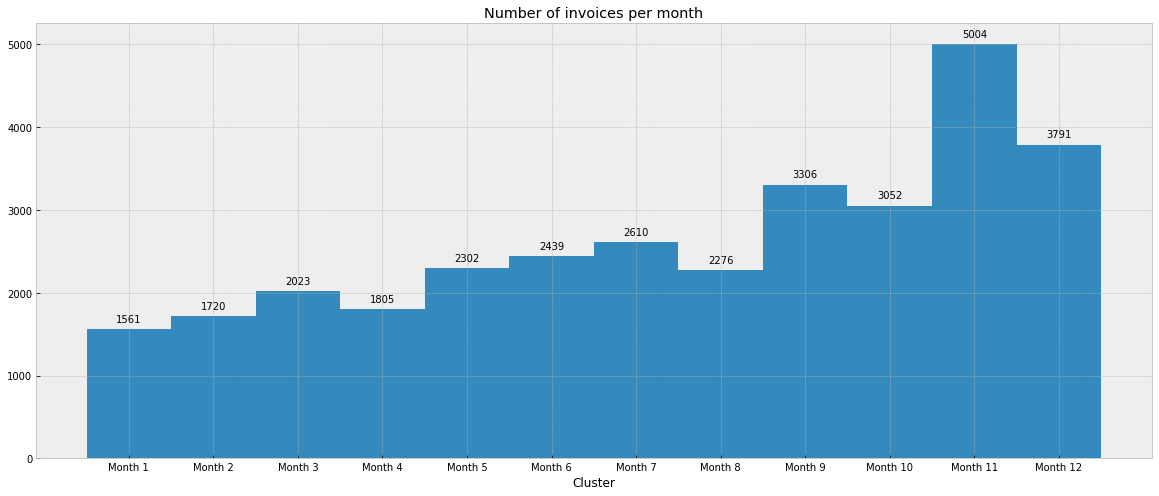

In [477]:
plt.figure(figsize = (20,8))
n, bins, patches = plt.hist(cluster7['Month'], bins=12)
plt.xlabel("Cluster")
plt.title("Number of invoices per month")
plt.xticks([rect.get_x()+ rect.get_width() / 2 for rect in patches], ["Month {}".format(x) for x in range(1, 13)])

for rect in patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2

    space = 5
    va = 'bottom'
    label = str(int(y_value))
    
    plt.annotate(
        label,                      
        (x_value, y_value),         
        xytext=(0, space),          
        textcoords="offset points", 
        ha='center',                
        va=va)

In [361]:
cluster7['Weekday'].nunique()

6

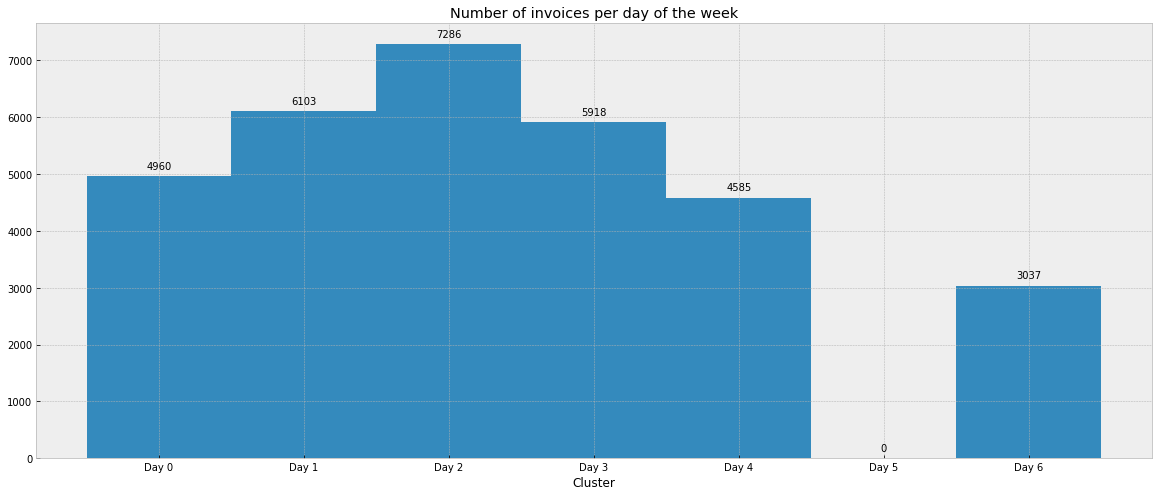

In [479]:
plt.figure(figsize = (20,8))
n, bins, patches = plt.hist(cluster7['Weekday'], bins=7)
plt.xlabel("Cluster")
plt.title("Number of invoices per day of the week")
plt.xticks([rect.get_x()+ rect.get_width() / 2 for rect in patches], ["Day {}".format(x) for x in range(0,7)])

for rect in patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2

    space = 5
    va = 'bottom'
    label = str(int(y_value))
    
    plt.annotate(
        label,                      
        (x_value, y_value),         
        xytext=(0, space),          
        textcoords="offset points", 
        ha='center',                
        va=va)

In [363]:
cluster7['Day'].nunique()

31

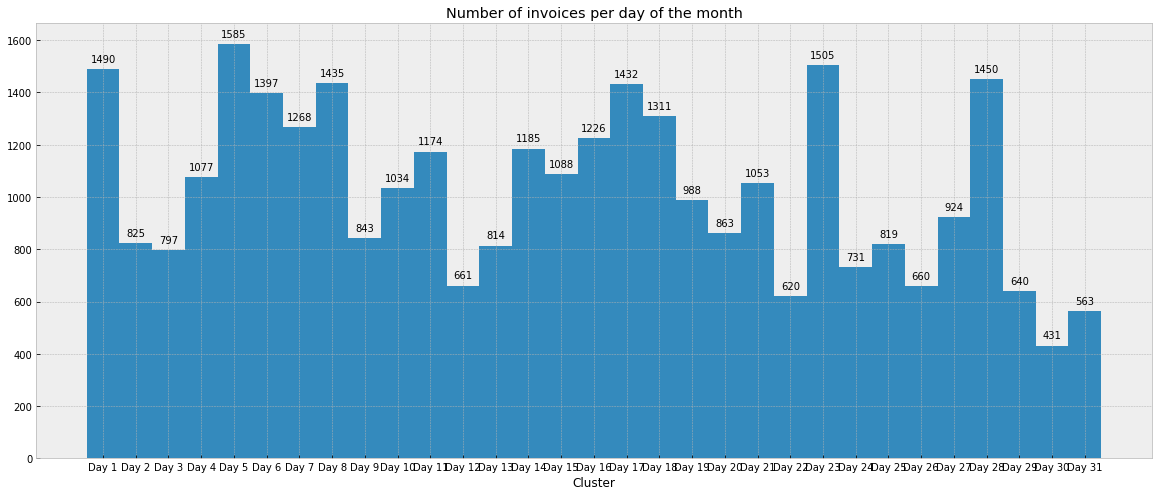

In [480]:
plt.figure(figsize = (20,8))
n, bins, patches = plt.hist(cluster7['Day'], bins=31)
plt.xlabel("Cluster")
plt.title("Number of invoices per day of the month")
plt.xticks([rect.get_x()+ rect.get_width() / 2 for rect in patches], ["Day {}".format(x) for x in range(1,32)])

for rect in patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2

    space = 5
    va = 'bottom'
    label = str(int(y_value))
    
    plt.annotate(
        label,                      
        (x_value, y_value),         
        xytext=(0, space),          
        textcoords="offset points", 
        ha='center',                
        va=va)

In [365]:
cluster7['Hour'].nunique()

14

In [473]:
cluster7['Hour'].value_counts()

12    5961
13    5139
14    4948
11    4427
10    3339
15    3088
9     1347
16    1132
17    1050
8      642
19     583
18     132
7       70
20      31
Name: Hour, dtype: int64

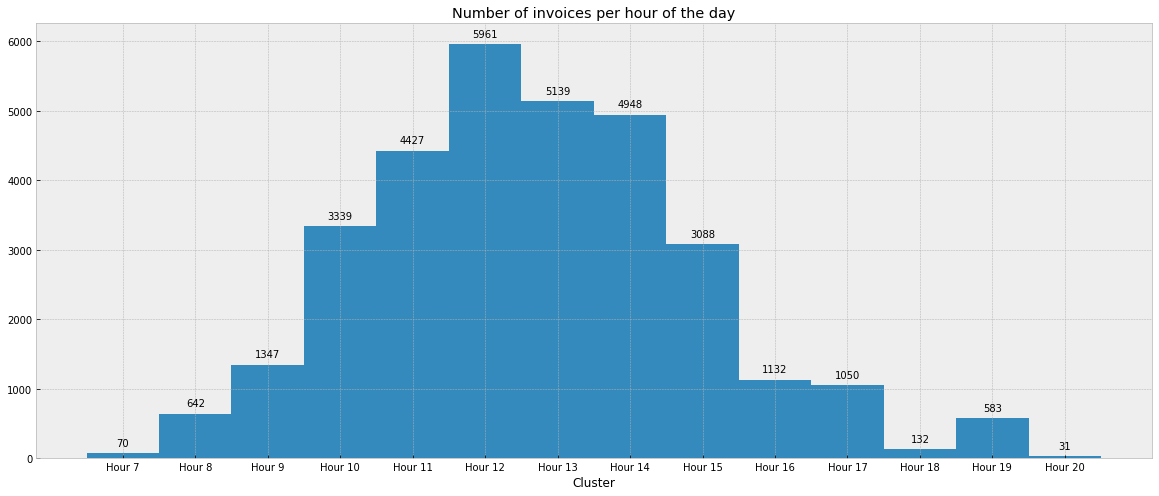

In [481]:
plt.figure(figsize = (20,8))
n, bins, patches = plt.hist(cluster7['Hour'], bins=14)
plt.xlabel("Cluster")
plt.title("Number of invoices per hour of the day")
plt.xticks([rect.get_x()+ rect.get_width() / 2 for rect in patches], ["Hour {}".format(x) for x in (sorted(cluster7['Hour'].unique()))])

for rect in patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2

    space = 5
    va = 'bottom'
    label = str(int(y_value))
    
    plt.annotate(
        label,                      
        (x_value, y_value),         
        xytext=(0, space),          
        textcoords="offset points", 
        ha='center',                
        va=va)

The cluster 7 contains 19 customers who are considered as best customers since they by the most, very frequently (75) and recently. The difference with cluster 2 is that they cluster 7's customers buy more frequently (75 vs 60) but have a lower monetary value (58000 vs 249000).
They have a mean basket price lower than the other clusters.

* Min Basket Price : 10
* Mean Basket Price : 138
* Max Basket Price : 648
* Quantity            23.257769
* UnitPrice            2.615444
* QuantityCanceled     0.109129
* TotalPrice          34.916436
* Frequency           121.570291
* Recency           2.599109

TOP 10 products bought :

* REGENCY CAKESTAND 3 TIER:              136
* JUMBO BAG RED RETROSPOT:               135
* WHITE HANGING HEART T-LIGHT HOLDER:    121
* CHILLI LIGHTS:                         102
* PAPER BUNTING RETROSPOT:                97
* LUNCH BAG  BLACK SKULL:                95
* GUMBALL COAT RACK:                      93
* LUNCH BAG RED RETROSPOT:                91
* JUMBO BAG PINK POLKADOT:                84
* LUNCH BAG CARS BLUE:                    81

## Cluster 6

In [367]:
final_dataset[final_dataset['cluster']==6]

,min,max,mean,min_recency,max_recency,frequency,monetary_value,quantity,country,cluster,...,Cluster_125,Cluster_126,Cluster_127,Cluster_128,Cluster_129,Cluster_130,Cluster_131,Cluster_132,Cluster_133,Cluster_134
CustomerID,,,,,,,,,,,,,,,,,,,,,
12603.0,613.20,613.20,613.200000,21.0,21.0,1,613.20,56,14,6,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
12678.0,2.08,1632.48,218.837778,42.0,353.0,9,16291.26,10900,13,6,...,0.000000,0.016149,0.000000,0.000000,0.000000,0.032066,0.007882,0.009568,0.000000,0.0
12755.0,5.95,2203.20,1104.575000,280.0,365.0,2,2220.75,1491,19,6,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
12798.0,515.52,3651.60,1961.840000,10.0,170.0,3,6977.04,5256,19,6,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.022290,0.000000,0.000000,0.0
12823.0,229.50,535.50,351.900000,74.0,296.0,5,1759.50,230,35,6,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
12830.0,51.84,587.52,298.320000,37.0,171.0,6,6814.64,9848,35,6,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.062865,0.0
12901.0,2.49,1519.80,316.067037,8.0,270.0,27,16298.86,22607,35,6,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.119507,0.008371,0.000000,0.001841,0.0
12908.0,318.00,432.00,375.000000,176.0,312.0,2,750.00,1200,35,6,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
12931.0,8.80,1125.00,279.265333,21.0,357.0,15,33756.11,27008,35,6,...,0.000000,0.000000,0.010664,0.000000,0.000000,0.000000,0.000000,0.020348,0.011870,0.0


In [368]:
final_dataset[final_dataset['cluster']==6].mean()

min                247.320161
max               1023.303871
mean               505.769998
min_recency         87.032258
max_recency        254.774194
frequency            8.209677
monetary_value    7999.587581
quantity          5655.403226
country             33.241935
cluster              6.000000
Cluster_0            0.001316
Cluster_1            0.008623
Cluster_2            0.002262
Cluster_3            0.000327
Cluster_4            0.000000
Cluster_5            0.000000
Cluster_6            0.016796
Cluster_7            0.000015
Cluster_8            0.018572
Cluster_9            0.000585
Cluster_10           0.000000
Cluster_11           0.021480
Cluster_12           0.001234
Cluster_13           0.000906
Cluster_14           0.007345
Cluster_15           0.003015
Cluster_16           0.040976
Cluster_17           0.028632
Cluster_18           0.000000
Cluster_19           0.000096
                     ...     
Cluster_105          0.001098
Cluster_106          0.000000
Cluster_10

In [235]:
cust6 = list(final_dataset[final_dataset['cluster']==6]['CustomerID'])


In [249]:
cluster6 = df_cleaned[df_cleaned['CustomerID'].isin(cust6)]
cluster6[['Quantity', 'UnitPrice', 'QuantityCanceled', 'TotalPrice', 'frequency', 'min_recency'
         , 'monetary_value']].mean()

Quantity              130.299145
UnitPrice               3.264359
QuantityCanceled        2.332590
TotalPrice            184.308595
frequency              19.621330
min_recency            16.435154
monetary_value      19315.532523
dtype: float64

In [438]:
cluster6['Description'].value_counts()[:10]

JUMBO BAG RED RETROSPOT               38
BLACK RECORD COVER FRAME              31
RECORD FRAME 7" SINGLE SIZE           28
REGENCY CAKESTAND 3 TIER              25
WORLD WAR 2 GLIDERS ASSTD DESIGNS     24
WHITE HANGING HEART T-LIGHT HOLDER    24
PARTY BUNTING                         24
LUNCH BOX I LOVE LONDON               23
RED  HARMONICA IN BOX                 23
CHILLI LIGHTS                         23
Name: Description, dtype: int64

In [395]:
custom_aggregation = {}
custom_aggregation["Country"] = lambda x:x.iloc[0]
custom_aggregation["RFMScore"] = lambda x:x.iloc[0]

cluster6_grouped = cluster6.groupby("CustomerID").agg(custom_aggregation)

In [396]:
cluster6_grouped['RFMScore'].value_counts()

111    17
443     6
311     5
432     4
221     4
211     3
121     3
243     2
343     2
321     2
431     2
442     2
222     1
322     1
241     1
231     1
131     1
232     1
441     1
411     1
332     1
122     1
Name: RFMScore, dtype: int64

In [439]:
cluster6_grouped['Country'].value_counts()

35    56
19     2
31     1
14     1
13     1
5      1
Name: Country, dtype: int64

In [398]:
cluster6['Month'].nunique()

12

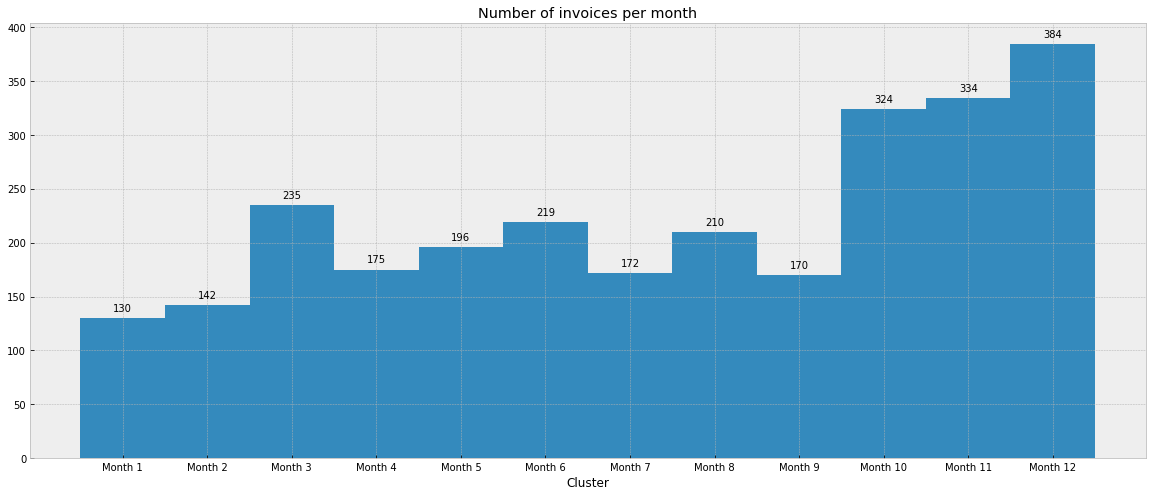

In [482]:
plt.figure(figsize = (20,8))
n, bins, patches = plt.hist(cluster6['Month'], bins=12)
plt.xlabel("Cluster")
plt.title("Number of invoices per month")
plt.xticks([rect.get_x()+ rect.get_width() / 2 for rect in patches], ["Month {}".format(x) for x in range(1, 13)])

for rect in patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2

    space = 5
    va = 'bottom'
    label = str(int(y_value))
    
    plt.annotate(
        label,                      
        (x_value, y_value),         
        xytext=(0, space),          
        textcoords="offset points", 
        ha='center',                
        va=va)

In [376]:
cluster6['Weekday'].nunique()

6

In [400]:
cluster6['Weekday'].unique()

array([2, 0, 3, 1, 4, 6])

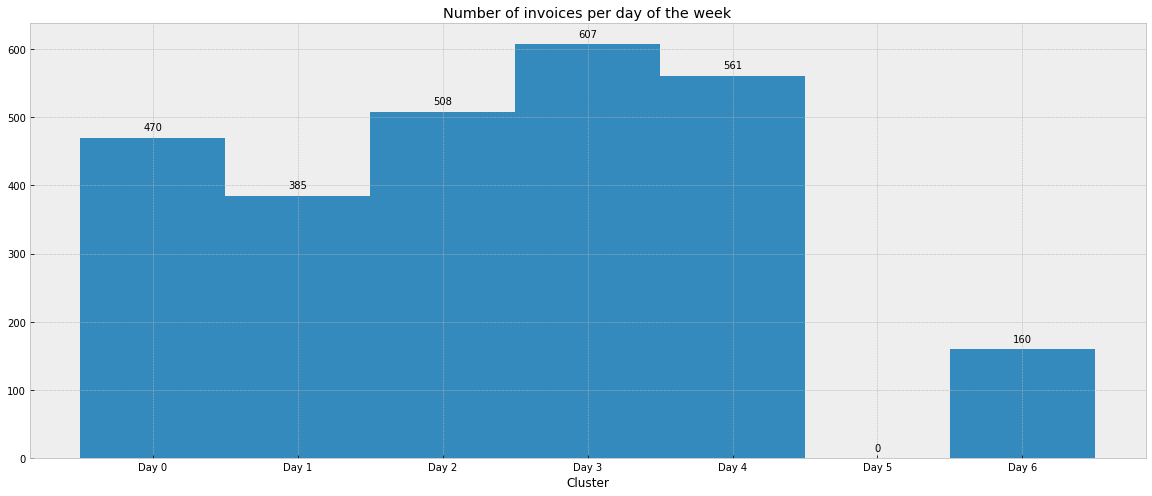

In [484]:
plt.figure(figsize = (20,8))
n, bins, patches = plt.hist(cluster6['Weekday'], bins=7)
plt.xlabel("Cluster")
plt.title("Number of invoices per day of the week")
plt.xticks([rect.get_x()+ rect.get_width() / 2 for rect in patches], ["Day {}".format(x) for x in range(0,7)])

for rect in patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2

    space = 5
    va = 'bottom'
    label = str(int(y_value))
    
    plt.annotate(
        label,                      
        (x_value, y_value),         
        xytext=(0, space),          
        textcoords="offset points", 
        ha='center',                
        va=va)

In [378]:
cluster6['Day'].nunique()

31

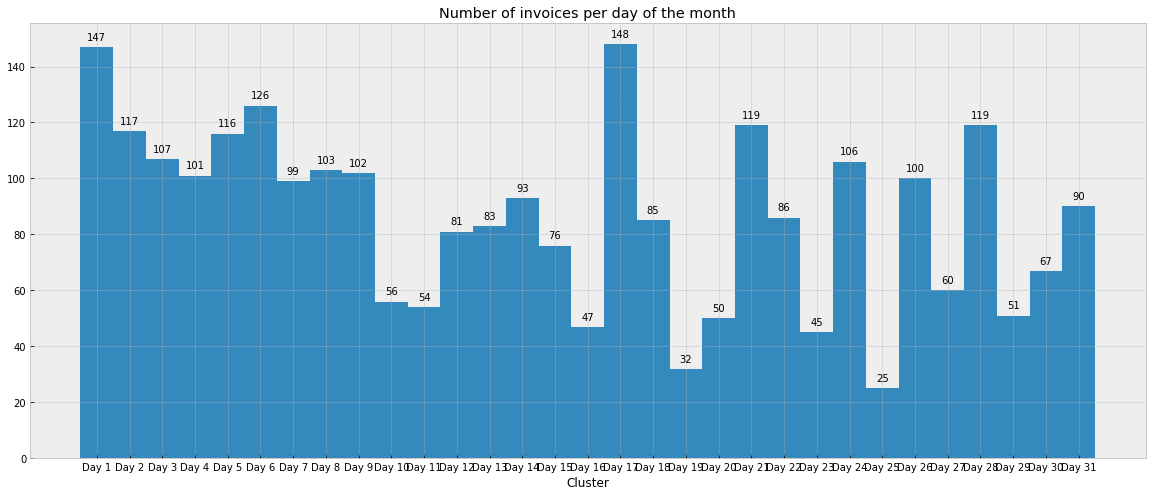

In [485]:
plt.figure(figsize = (20,8))
n, bins, patches = plt.hist(cluster6['Day'], bins=31)
plt.xlabel("Cluster")
plt.title("Number of invoices per day of the month")
plt.xticks([rect.get_x()+ rect.get_width() / 2 for rect in patches], ["Day {}".format(x) for x in range(1,32)])

for rect in patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2

    space = 5
    va = 'bottom'
    label = str(int(y_value))
    
    plt.annotate(
        label,                      
        (x_value, y_value),         
        xytext=(0, space),          
        textcoords="offset points", 
        ha='center',                
        va=va)

In [486]:
cluster6['Hour'].nunique()

12

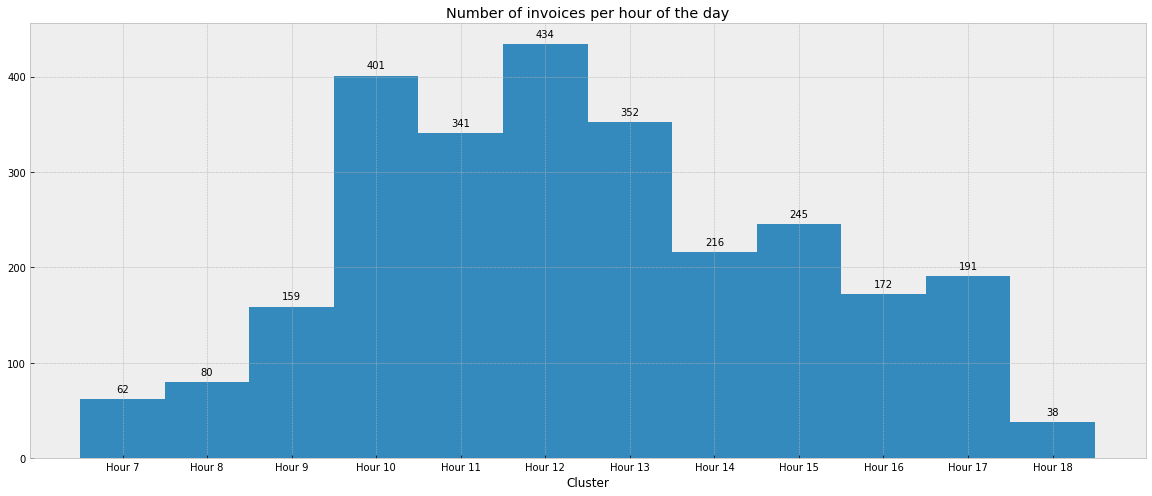

In [487]:
plt.figure(figsize = (20,8))
n, bins, patches = plt.hist(cluster6['Hour'], bins=12)
plt.xlabel("Cluster")
plt.title("Number of invoices per hour of the day")
plt.xticks([rect.get_x()+ rect.get_width() / 2 for rect in patches], ["Hour {}".format(x) for x in (sorted(cluster6['Hour'].unique()))])

for rect in patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2

    space = 5
    va = 'bottom'
    label = str(int(y_value))
    
    plt.annotate(
        label,                      
        (x_value, y_value),         
        xytext=(0, space),          
        textcoords="offset points", 
        ha='center',                
        va=va)

This cluster is quiete heterogeneous since there are 17 best customers, 6 lost cheap customers and so on. They do have a high mean basket price of 505 but it's mostly due to the mean quantity they buy (130) because the mean unit price is very low (3.26)

For the time features, what is interesting is that these customers shop less on weekend and they shopped more at the end of the year.

* Min Basket Price : 247
* Mean Basket Price : 505
* Max Basket Price : 1023
* Quantity            130.299145
* UnitPrice             3.264359
* QuantityCanceled      2.332590
* TotalPrice          184.308595

TOP 10 products bought :

* JUMBO BAG RED RETROSPOT :               38
* BLACK RECORD COVER FRAME :            31
* RECORD FRAME 7" SINGLE SIZE :         28
* REGENCY CAKESTAND 3 TIER :           25
* WORLD WAR 2 GLIDERS ASSTD DESIGNS :    24
* WHITE HANGING HEART T-LIGHT HOLDER :   24
* PARTY BUNTING :                        24
* LUNCH BOX I LOVE LONDON :               23
* RED  HARMONICA IN BOX :                23
* CHILLI LIGHTS :                        23

## Cluster 3

In [404]:
final_dataset[final_dataset['cluster']==3]

,min,max,mean,min_recency,max_recency,frequency,monetary_value,quantity,country,cluster,...,Cluster_125,Cluster_126,Cluster_127,Cluster_128,Cluster_129,Cluster_130,Cluster_131,Cluster_132,Cluster_133,Cluster_134
CustomerID,,,,,,,,,,,,,,,,,,,,,
12347.0,13.20,45.00,23.308571,2.0,367.0,7,4310.00,2458,16,3,...,0.000000,0.026729,0.000000,0.000000,0.000000,0.042877,0.000000,0.007494,0.046775,0.0
12348.0,39.60,150.00,82.840000,75.0,358.0,4,1437.24,2332,12,3,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.204559,0.159806,0.000000,0.000000,0.0
12349.0,15.00,15.00,15.000000,18.0,18.0,1,1457.55,630,18,3,...,0.000000,0.004556,0.000000,0.044458,0.000000,0.004556,0.000000,0.000000,0.000000,0.0
12353.0,19.90,19.90,19.900000,204.0,204.0,1,89.00,20,2,3,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.198876,0.000000,0.000000,0.000000,0.0
12355.0,30.00,30.00,30.000000,214.0,214.0,1,459.40,240,2,3,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.115586,0.0
12358.0,15.00,142.80,78.900000,1.0,150.0,2,928.06,242,1,3,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.031291,0.000000,0.000000,0.000000,0.0
12359.0,10.00,34.00,20.175000,57.0,331.0,4,6140.48,1607,7,3,...,0.000000,0.000000,0.000000,0.002687,0.010292,0.000000,0.002795,0.002264,0.030030,0.0
12360.0,10.20,20.80,15.433333,52.0,200.0,3,2302.06,1156,1,3,...,0.000000,0.016655,0.004431,0.000000,0.000000,0.000000,0.012250,0.008601,0.000000,0.0
12361.0,23.40,23.40,23.400000,287.0,287.0,1,174.90,90,3,3,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0


In [405]:
final_dataset[final_dataset['cluster']==3].mean()

min                 20.585405
max                 59.317466
mean                33.553136
min_recency         91.858108
max_recency        222.472973
frequency            3.891892
monetary_value    1914.037466
quantity          1111.003378
country             11.628378
cluster              3.000000
Cluster_0            0.000738
Cluster_1            0.014936
Cluster_2            0.011232
Cluster_3            0.000211
Cluster_4            0.002211
Cluster_5            0.000169
Cluster_6            0.009014
Cluster_7            0.001263
Cluster_8            0.005408
Cluster_9            0.001077
Cluster_10           0.010347
Cluster_11           0.029224
Cluster_12           0.010031
Cluster_13           0.000833
Cluster_14           0.019146
Cluster_15           0.016794
Cluster_16           0.012131
Cluster_17           0.005215
Cluster_18           0.001406
Cluster_19           0.004160
                     ...     
Cluster_105          0.026890
Cluster_106          0.000124
Cluster_10

In [237]:
cust3 = list(final_dataset[final_dataset['cluster']==3]['CustomerID'])


In [250]:
cluster3 = df_cleaned[df_cleaned['CustomerID'].isin(cust3)]
cluster3[['Quantity', 'UnitPrice', 'QuantityCanceled', 'TotalPrice', 'frequency', 'min_recency'
         , 'monetary_value']].mean()

Quantity              13.785663
UnitPrice              2.884687
QuantityCanceled       0.057975
TotalPrice            23.749951
frequency              7.865563
min_recency           46.622343
monetary_value      4485.184052
dtype: float64

In [428]:
cluster3['Description'].value_counts()[:10]

ROUND SNACK BOXES SET OF4 WOODLAND     233
REGENCY CAKESTAND 3 TIER               161
PLASTERS IN TIN WOODLAND ANIMALS       150
ROUND SNACK BOXES SET OF 4 FRUITS      146
RED TOADSTOOL LED NIGHT LIGHT          144
PLASTERS IN TIN CIRCUS PARADE          141
SPACEBOY LUNCH BOX                     137
RABBIT NIGHT LIGHT                     120
PLASTERS IN TIN SPACEBOY               120
WOODLAND CHARLOTTE BAG                 111
Name: Description, dtype: int64

In [429]:
custom_aggregation = {}
custom_aggregation["Country"] = lambda x:x.iloc[0]
custom_aggregation["RFMScore"] = lambda x:x.iloc[0]

cluster3_grouped = cluster3.groupby("CustomerID").agg(custom_aggregation)

In [430]:
cluster3_grouped['RFMScore'].value_counts()

111    32
444    24
211    21
322    17
443    16
343    11
122    10
321    10
332    10
121     9
221     8
243     8
222     7
342     7
344     7
132     6
433     6
442     6
244     6
144     6
233     5
431     5
333     5
223     4
441     4
432     4
133     4
331     3
334     3
123     3
232     3
323     3
421     3
231     3
112     2
234     2
341     2
143     2
311     2
423     2
242     1
212     1
324     1
142     1
131     1
Name: RFMScore, dtype: int64

In [431]:
cluster3_grouped['Country'].value_counts()

14    93
13    86
3     24
18    12
12    12
1      9
6      9
0      8
9      8
7      7
19     6
15     4
5      3
23     3
17     3
22     2
2      2
8      1
11     1
4      1
16     1
10     1
Name: Country, dtype: int64

In [432]:
cluster3['Month'].nunique()

12

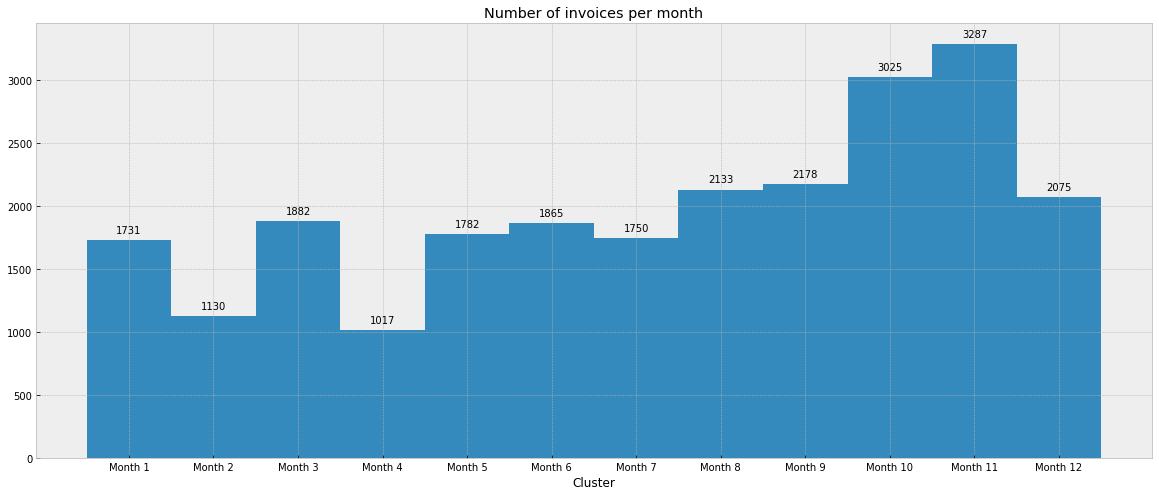

In [489]:
plt.figure(figsize = (20,8))
n, bins, patches = plt.hist(cluster3['Month'], bins=12)
plt.xlabel("Cluster")
plt.title("Number of invoices per month")
plt.xticks([rect.get_x()+ rect.get_width() / 2 for rect in patches], ["Month {}".format(x) for x in range(1, 13)])

for rect in patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2

    space = 5
    va = 'bottom'
    label = str(int(y_value))
    
    plt.annotate(
        label,                      
        (x_value, y_value),         
        xytext=(0, space),          
        textcoords="offset points", 
        ha='center',                
        va=va)

In [416]:
cluster3['Weekday'].nunique()

6

In [417]:
cluster6['Weekday'].unique()

array([2, 0, 3, 1, 4, 6])

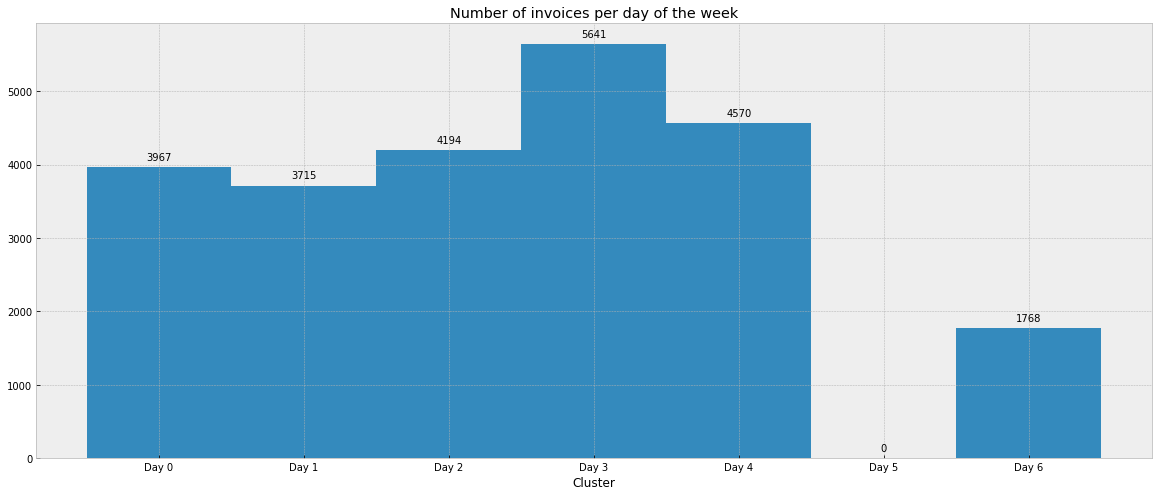

In [490]:
plt.figure(figsize = (20,8))
n, bins, patches = plt.hist(cluster3['Weekday'], bins=7)
plt.xlabel("Cluster")
plt.title("Number of invoices per day of the week")
plt.xticks([rect.get_x()+ rect.get_width() / 2 for rect in patches], ["Day {}".format(x) for x in range(0,7)])

for rect in patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2

    space = 5
    va = 'bottom'
    label = str(int(y_value))
    
    plt.annotate(
        label,                      
        (x_value, y_value),         
        xytext=(0, space),          
        textcoords="offset points", 
        ha='center',                
        va=va)

In [419]:
cluster3['Day'].nunique()

31

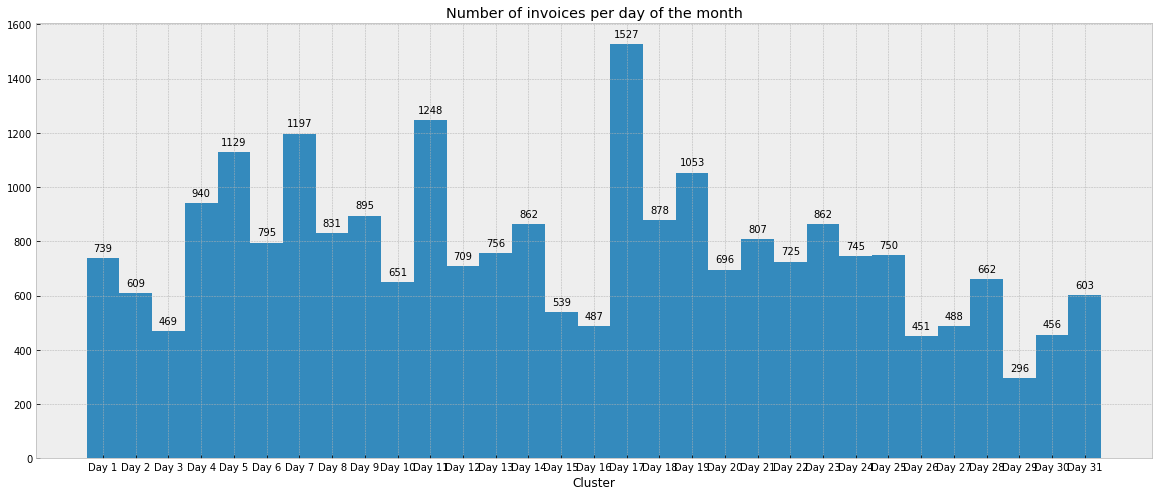

In [491]:
plt.figure(figsize = (20,8))
n, bins, patches = plt.hist(cluster3['Day'], bins=31)
plt.xlabel("Cluster")
plt.title("Number of invoices per day of the month")
plt.xticks([rect.get_x()+ rect.get_width() / 2 for rect in patches], ["Day {}".format(x) for x in range(1,32)])

for rect in patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2

    space = 5
    va = 'bottom'
    label = str(int(y_value))
    
    plt.annotate(
        label,                      
        (x_value, y_value),         
        xytext=(0, space),          
        textcoords="offset points", 
        ha='center',                
        va=va)

In [423]:
cluster3['Hour'].nunique()

13

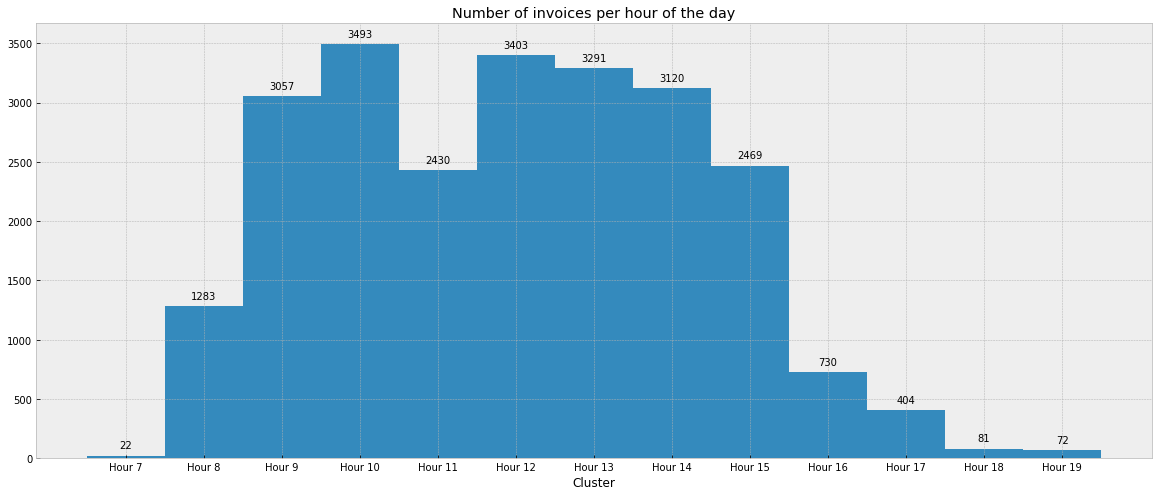

In [492]:
plt.figure(figsize = (20,8))
n, bins, patches = plt.hist(cluster3['Hour'], bins=13)
plt.xlabel("Cluster")
plt.title("Number of invoices per hour of the day")
plt.xticks([rect.get_x()+ rect.get_width() / 2 for rect in patches], ["Hour {}".format(x) for x in (sorted(cluster3['Hour'].unique()))])

for rect in patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2

    space = 5
    va = 'bottom'
    label = str(int(y_value))
    
    plt.annotate(
        label,                      
        (x_value, y_value),         
        xytext=(0, space),          
        textcoords="offset points", 
        ha='center',                
        va=va)

What is very specific about this cluster is that there are no customers from UK, it's only foreign countries (Germany, France, Belgium, Italy and Finland).
This cluster is also heterogeneous in terms of RFM since the 2 most represented categories are Best customer and Lost cheap customer. The average basket is very low (33) comparing the ones above but I guess that the more customers we have in a cluster and the more the average customer will be represented which doesn't spent 500$ per transactions like the ones above. 

October and november have the most invoices which isn't surpring approaching Christmas. 

Key figures: 
* Min Basket Price: 20.58
* Mean Basket Price: 33.55
* Max Basket Price: 59.31

* Quantity:            13.785663
* UnitPrice:           2.884687
* QuantityCanceled:     0.057975
* TotalPrice:          23.749951
* Frequency            7.865563
* Recency         46.622343

TOP 10 bought products :

* ROUND SNACK BOXES SET OF4 WOODLAND:     233
* REGENCY CAKESTAND 3 TIER:               161
* PLASTERS IN TIN WOODLAND ANIMALS:       150
* ROUND SNACK BOXES SET OF 4 FRUITS:      146
* RED TOADSTOOL LED NIGHT LIGHT:          144
* PLASTERS IN TIN CIRCUS PARADE:          141
* SPACEBOY LUNCH BOX:                     137
* RABBIT NIGHT LIGHT:                     120
* PLASTERS IN TIN SPACEBOY:               120
* WOODLAND CHARLOTTE BAG:                 111

## Cluster 0

In [440]:
final_dataset[final_dataset['cluster']==0]

,min,max,mean,min_recency,max_recency,frequency,monetary_value,quantity,country,cluster,...,Cluster_125,Cluster_126,Cluster_127,Cluster_128,Cluster_129,Cluster_130,Cluster_131,Cluster_132,Cluster_133,Cluster_134
CustomerID,,,,,,,,,,,,,,,,,,,,,
12350.0,25.20,25.20,25.200000,310.0,310.0,1,294.40,196,24,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.050951,0.000000,0.0
12354.0,20.80,20.80,20.800000,232.0,232.0,1,1079.40,530,30,0,...,0.000000,0.000000,0.000000,0.015286,0.000000,0.000000,0.000000,0.000000,0.013850,0.0
12377.0,19.80,37.20,28.500000,315.0,354.0,2,1548.12,942,32,0,...,0.000000,0.045578,0.010658,0.000000,0.000000,0.009689,0.000000,0.000000,0.000000,0.0
12410.0,17.00,17.00,17.000000,308.0,308.0,2,521.08,207,32,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
12510.0,33.00,162.72,97.860000,142.0,325.0,2,814.57,347,30,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.018415,0.0
12515.0,17.00,17.00,17.000000,353.0,353.0,1,278.70,128,18,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.177072,0.000000,0.000000,0.063509,0.0
12547.0,20.40,30.00,25.200000,197.0,280.0,2,151.80,132,30,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.201581,0.000000,0.000000,0.0
12548.0,17.40,17.40,17.400000,166.0,166.0,1,67.20,48,30,0,...,0.000000,0.000000,0.223214,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
12551.0,19.50,19.50,19.500000,357.0,357.0,1,168.00,100,30,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0


In [441]:
final_dataset[final_dataset['cluster']==0].mean()

min                24.209597
max                34.521695
mean               28.913496
min_recency       250.960805
max_recency       281.919492
frequency           1.616525
monetary_value    437.690593
quantity          237.667373
country            34.772246
cluster             0.000000
Cluster_0           0.000824
Cluster_1           0.015188
Cluster_2           0.006277
Cluster_3           0.001781
Cluster_4           0.002450
Cluster_5           0.000466
Cluster_6           0.013273
Cluster_7           0.000461
Cluster_8           0.006485
Cluster_9           0.000000
Cluster_10          0.001560
Cluster_11          0.031794
Cluster_12          0.005578
Cluster_13          0.000445
Cluster_14          0.012648
Cluster_15          0.010385
Cluster_16          0.018727
Cluster_17          0.007082
Cluster_18          0.010257
Cluster_19          0.002445
                     ...    
Cluster_105         0.008960
Cluster_106         0.000750
Cluster_107         0.000211
Cluster_108   

In [239]:
cust0 = list(final_dataset[final_dataset['cluster']==0]['CustomerID'])


In [251]:
cluster0 = df_cleaned[df_cleaned['CustomerID'].isin(cust0)]
cluster0[['Quantity', 'UnitPrice', 'QuantityCanceled', 'TotalPrice', 'frequency', 'min_recency'
         , 'monetary_value']].mean()

Quantity              8.256956
UnitPrice             3.292300
QuantityCanceled      0.047880
TotalPrice           15.206092
frequency             2.606359
min_recency         237.013433
monetary_value      840.042826
dtype: float64

In [456]:
cluster0['Description'].value_counts()[:10]

WHITE HANGING HEART T-LIGHT HOLDER    227
REGENCY CAKESTAND 3 TIER              182
PARTY BUNTING                         137
ASSORTED COLOUR BIRD ORNAMENT         125
REX CASH+CARRY JUMBO SHOPPER          103
SET OF 3 CAKE TINS PANTRY DESIGN      100
NATURAL SLATE HEART CHALKBOARD        100
JAM MAKING SET WITH JARS               99
HEART OF WICKER SMALL                  98
HEART OF WICKER LARGE                  86
Name: Description, dtype: int64

In [457]:
custom_aggregation = {}
custom_aggregation["Country"] = lambda x:x.iloc[0]
custom_aggregation["RFMScore"] = lambda x:x.iloc[0]

cluster0_grouped = cluster0.groupby("CustomerID").agg(custom_aggregation)

In [458]:
cluster0_grouped['RFMScore'].value_counts()

444    402
443    181
433     92
434     53
432     49
422     44
423     36
442     30
424     12
421      9
412      6
411      6
431      4
332      4
441      3
322      3
321      2
414      2
323      2
333      2
334      1
413      1
Name: RFMScore, dtype: int64

In [459]:
cluster0_grouped['Country'].value_counts()

35    915
26      6
32      5
30      5
23      2
18      2
36      1
34      1
33      1
31      1
28      1
25      1
24      1
21      1
20      1
Name: Country, dtype: int64

In [460]:
cluster0['Month'].nunique()

9

In [461]:
cluster0['Month'].value_counts()

12    5232
3     4209
5     3677
4     3537
2     3390
1     3116
6     3019
7      978
8       14
Name: Month, dtype: int64

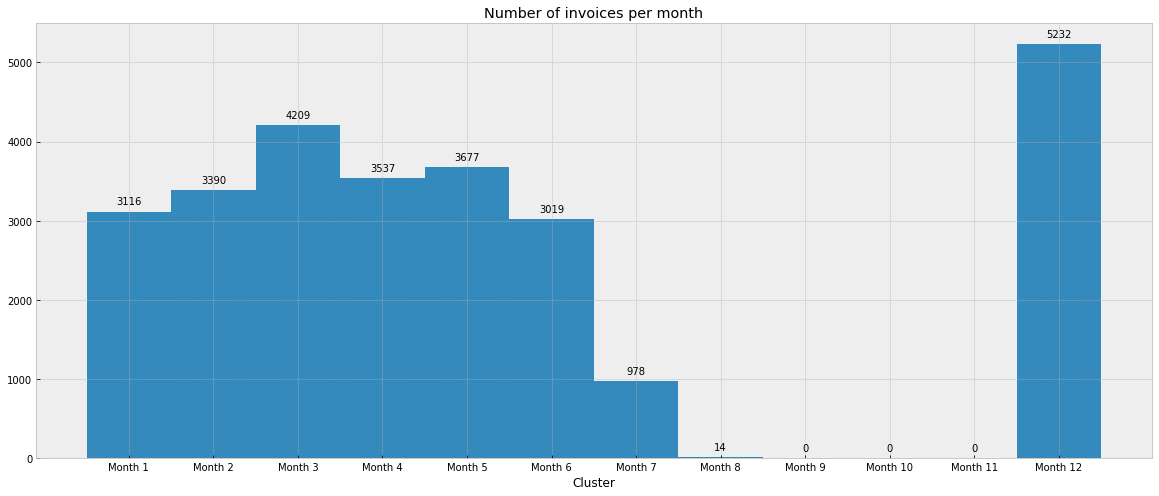

In [493]:
plt.figure(figsize = (20,8))
n, bins, patches = plt.hist(cluster0['Month'], bins=12)
plt.xlabel("Cluster")
plt.title("Number of invoices per month")
plt.xticks([rect.get_x()+ rect.get_width() / 2 for rect in patches], ["Month {}".format(x) for x in range(1, 13)])

for rect in patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2

    space = 5
    va = 'bottom'
    label = str(int(y_value))
    
    plt.annotate(
        label,                      
        (x_value, y_value),         
        xytext=(0, space),          
        textcoords="offset points", 
        ha='center',                
        va=va)

In [504]:
temp['Year'] = cluster0[cluster0['Month']==12]['InvoiceDate'].map(lambda x: x.year)
temp['Year'].value_counts()

2010.0    707
Name: Year, dtype: int64

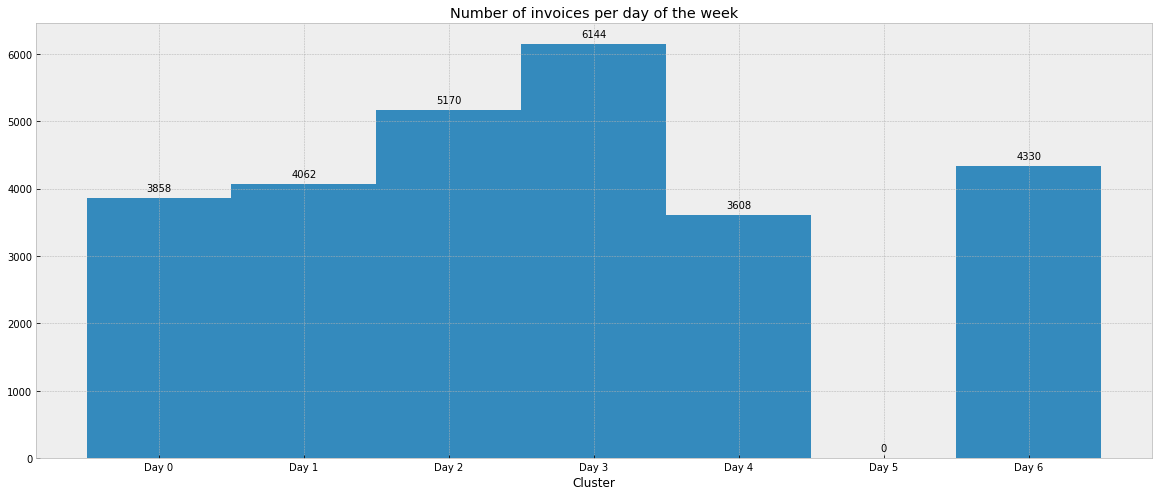

In [494]:
plt.figure(figsize = (20,8))
n, bins, patches = plt.hist(cluster0['Weekday'], bins=7)
plt.xlabel("Cluster")
plt.title("Number of invoices per day of the week")
plt.xticks([rect.get_x()+ rect.get_width() / 2 for rect in patches], ["Day {}".format(x) for x in range(0, 7)])

for rect in patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2

    space = 5
    va = 'bottom'
    label = str(int(y_value))
    
    plt.annotate(
        label,                      
        (x_value, y_value),         
        xytext=(0, space),          
        textcoords="offset points", 
        ha='center',                
        va=va)

In [419]:
cluster3['Day'].nunique()

31

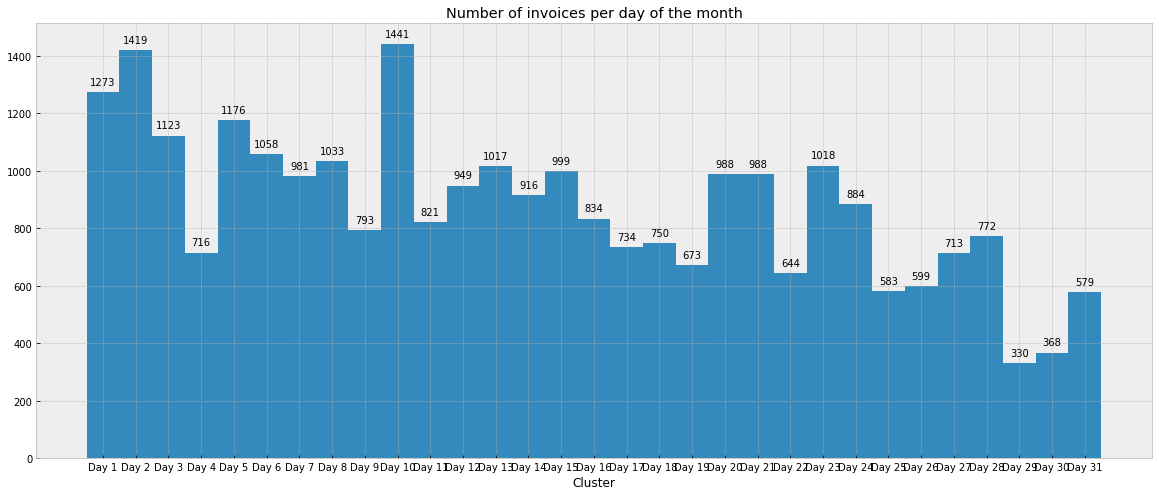

In [501]:
plt.figure(figsize = (20,8))
n, bins, patches = plt.hist(cluster0['Day'], bins=31)
plt.xlabel("Cluster")
plt.title("Number of invoices per day of the month")
plt.xticks([rect.get_x()+ rect.get_width() / 2 for rect in patches], ["Day {}".format(x) for x in range(1,32)])

for rect in patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2

    space = 5
    va = 'bottom'
    label = str(int(y_value))
    
    plt.annotate(
        label,                      
        (x_value, y_value),         
        xytext=(0, space),          
        textcoords="offset points", 
        ha='center',                
        va=va)

In [500]:
cluster0['Hour'].nunique()

14

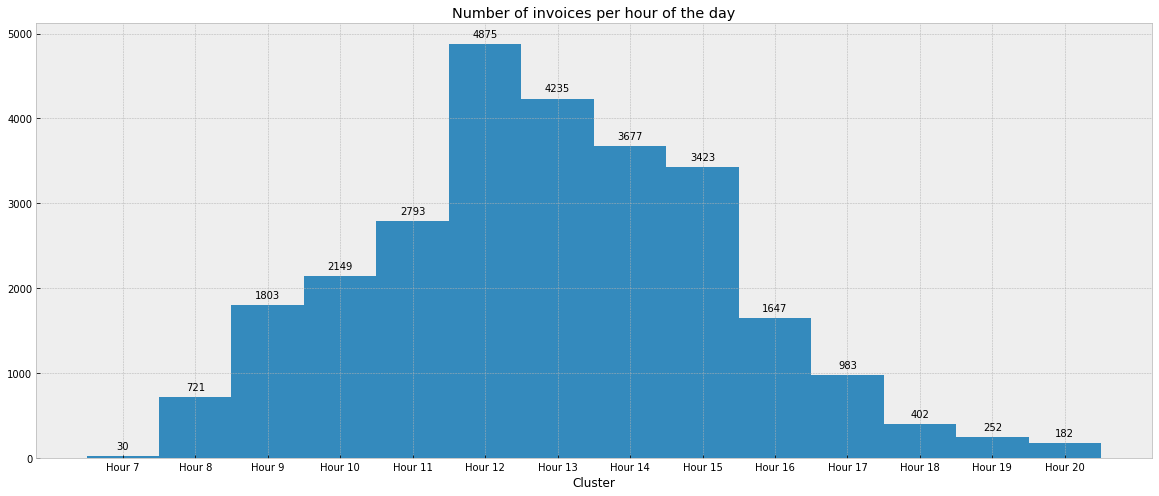

In [502]:
plt.figure(figsize = (20,8))
n, bins, patches = plt.hist(cluster0['Hour'], bins=14)
plt.xlabel("Cluster")
plt.title("Number of invoices per hour of the day")
plt.xticks([rect.get_x()+ rect.get_width() / 2 for rect in patches], ["Hour {}".format(x) for x in (sorted(cluster0['Hour'].unique()))])

for rect in patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2

    space = 5
    va = 'bottom'
    label = str(int(y_value))
    
    plt.annotate(
        label,                      
        (x_value, y_value),         
        xytext=(0, space),          
        textcoords="offset points", 
        ha='center',                
        va=va)

This cluster is full of lost customers. Indeed, as we can see in the month histogramm there are almost no invoices after july. We can see that there are in december but it's december of the past year. So this cluster is pretty bad for datazone, they don't want to have new customers in there. Furthermore they are cheap customers since the mean basket price is 28.91$ ... 



Key figures: 
* Min Basket Price: 24.20
* Mean Basket Price: 28.91
* Max Basket Price: 34.52

* Quantity:            8.25
* UnitPrice:           3.29
* QuantityCanceled:     0.04
* TotalPrice:          15.20
* Frequency             2.606359
* Recency         237.013433

TOP 10 bought products :

* WHITE HANGING HEART T-LIGHT HOLDER:    227
* REGENCY CAKESTAND 3 TIER:              182
* PARTY BUNTING:                         137
* ASSORTED COLOUR BIRD ORNAMENT:         125
* REX CASH+CARRY JUMBO SHOPPER:          103
* SET OF 3 CAKE TINS PANTRY DESIGN:      100
* NATURAL SLATE HEART CHALKBOARD:        100
* JAM MAKING SET WITH JARS:               99
* HEART OF WICKER SMALL:                  98
* HEART OF WICKER LARGE:                  86

## Cluster 5

In [505]:
final_dataset[final_dataset['cluster']==5]

,min,max,mean,min_recency,max_recency,frequency,monetary_value,quantity,country,cluster,...,Cluster_125,Cluster_126,Cluster_127,Cluster_128,Cluster_129,Cluster_130,Cluster_131,Cluster_132,Cluster_133,Cluster_134
CustomerID,,,,,,,,,,,,,,,,,,,,,
12357.0,19.80,19.80,19.800000,33.0,33.0,1,6207.67,2708,32,5,...,0.000000,0.000000,0.000000,0.023216,0.000000,0.017108,0.000000,0.000000,0.016354,0.0
12371.0,5.04,5.04,5.040000,59.0,59.0,1,1527.96,582,32,5,...,0.000000,0.016336,0.000000,0.027815,0.000000,0.000000,0.003063,0.000000,0.000000,0.0
12378.0,12.60,12.60,12.600000,129.0,129.0,1,4008.62,2529,32,5,...,0.000000,0.013681,0.003742,0.000000,0.000000,0.005837,0.047059,0.000000,0.007459,0.0
12381.0,15.00,29.70,21.533333,4.0,119.0,3,1433.46,785,24,5,...,0.000000,0.047675,0.022603,0.011720,0.000000,0.064097,0.000000,0.013813,0.016324,0.0
12384.0,15.00,25.00,20.000000,28.0,121.0,2,406.16,122,32,5,...,0.000000,0.049192,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
12398.0,15.00,15.00,15.000000,45.0,45.0,1,1435.66,1389,32,5,...,0.000000,0.023320,0.000000,0.000000,0.000000,0.061045,0.072301,0.000000,0.010448,0.0
12409.0,62.40,79.20,70.800000,78.0,182.0,2,11056.93,5550,32,5,...,0.009008,0.013512,0.000000,0.004477,0.000000,0.018233,0.003799,0.000000,0.011070,0.0
12418.0,10.08,10.08,10.080000,112.0,112.0,1,668.58,407,32,5,...,0.000000,0.030153,0.000000,0.000000,0.000000,0.000000,0.027820,0.000000,0.022436,0.0
12425.0,8.50,8.50,8.500000,78.0,78.0,1,777.20,496,26,5,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.016984,0.000000,0.000000,0.000000,0.0


In [506]:
final_dataset[final_dataset['cluster']==5].mean()

min                20.833118
max                33.778961
mean               26.439774
min_recency        49.821060
max_recency        86.591191
frequency           1.925671
monetary_value    639.926910
quantity          421.159670
country            34.807983
cluster             5.000000
Cluster_0           0.001370
Cluster_1           0.007290
Cluster_2           0.005615
Cluster_3           0.000604
Cluster_4           0.008559
Cluster_5           0.000111
Cluster_6           0.011402
Cluster_7           0.001495
Cluster_8           0.008645
Cluster_9           0.000418
Cluster_10          0.001962
Cluster_11          0.016675
Cluster_12          0.011760
Cluster_13          0.007562
Cluster_14          0.011231
Cluster_15          0.011946
Cluster_16          0.021241
Cluster_17          0.005441
Cluster_18          0.006696
Cluster_19          0.001728
                     ...    
Cluster_105         0.009090
Cluster_106         0.001358
Cluster_107         0.000135
Cluster_108   

In [241]:
cust5 = list(final_dataset[final_dataset['cluster']==5]['CustomerID'])


In [252]:
cluster5 = df_cleaned[df_cleaned['CustomerID'].isin(cust5)]
cluster5[['Quantity', 'UnitPrice', 'QuantityCanceled', 'TotalPrice', 'frequency', 'min_recency'
         , 'monetary_value']].mean()

Quantity               9.063166
UnitPrice              2.683396
QuantityCanceled       0.028436
TotalPrice            13.770939
frequency              3.065758
min_recency           36.131902
monetary_value      1201.427154
dtype: float64

In [509]:
cluster5['Description'].value_counts()[:10]

PAPER CHAIN KIT 50'S CHRISTMAS        267
BAKING SET 9 PIECE RETROSPOT          263
WHITE HANGING HEART T-LIGHT HOLDER    250
ASSORTED COLOUR BIRD ORNAMENT         247
REX CASH+CARRY JUMBO SHOPPER          223
HOT WATER BOTTLE KEEP CALM            215
REGENCY CAKESTAND 3 TIER              208
RABBIT NIGHT LIGHT                    200
GARDENERS KNEELING PAD KEEP CALM      194
SPOTTY BUNTING                        193
Name: Description, dtype: int64

In [510]:
custom_aggregation = {}
custom_aggregation["Country"] = lambda x:x.iloc[0]
custom_aggregation["RFMScore"] = lambda x:x.iloc[0]

cluster5_grouped = cluster5.groupby("CustomerID").agg(custom_aggregation)

In [511]:
cluster5_grouped['RFMScore'].value_counts()

344    199
244    138
343    135
243     87
222     65
122     59
144     57
233     50
133     48
333     48
342     45
232     42
332     39
132     37
121     32
143     31
234     29
123     27
223     27
111     26
134     25
444     23
242     18
323     17
322     16
334     16
443     15
221     13
341     12
112     12
124      8
331      7
434      6
321      6
324      5
224      5
211      4
131      4
212      3
442      3
142      3
241      2
311      2
231      2
424      1
441      1
423      1
432      1
433      1
Name: RFMScore, dtype: int64

In [512]:
cluster5_grouped['Country'].value_counts()

35    1408
32       9
30       9
26       7
24       7
31       4
25       3
36       2
34       1
33       1
27       1
23       1
Name: Country, dtype: int64

In [513]:
cluster5['Month'].nunique()

8

In [514]:
cluster5['Month'].value_counts()

11    20747
10    16891
9     10849
7      4987
8      4926
12     4880
6      2837
5      1403
Name: Month, dtype: int64

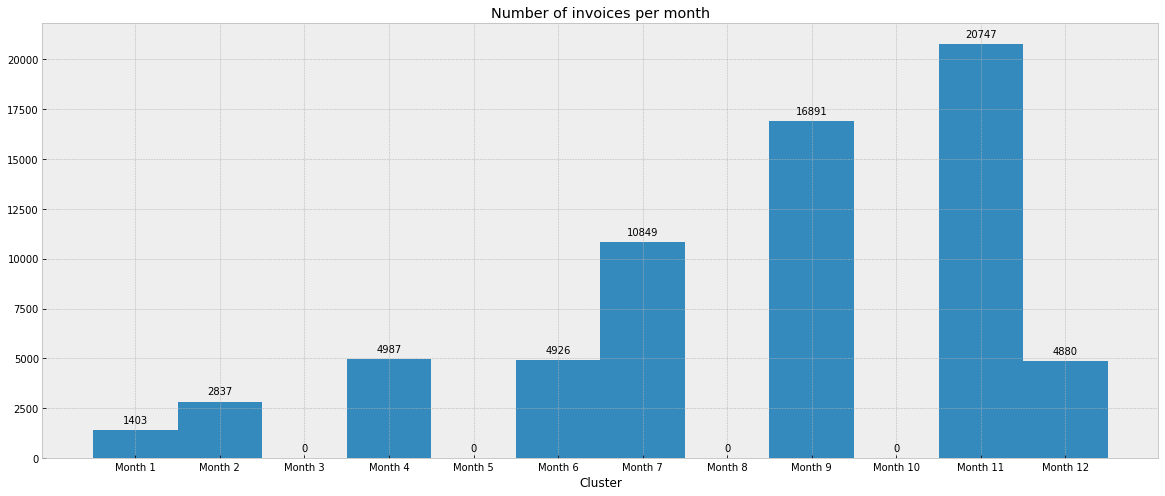

In [515]:
plt.figure(figsize = (20,8))
n, bins, patches = plt.hist(cluster5['Month'], bins=12)
plt.xlabel("Cluster")
plt.title("Number of invoices per month")
plt.xticks([rect.get_x()+ rect.get_width() / 2 for rect in patches], ["Month {}".format(x) for x in range(1, 13)])

for rect in patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2

    space = 5
    va = 'bottom'
    label = str(int(y_value))
    
    plt.annotate(
        label,                      
        (x_value, y_value),         
        xytext=(0, space),          
        textcoords="offset points", 
        ha='center',                
        va=va)

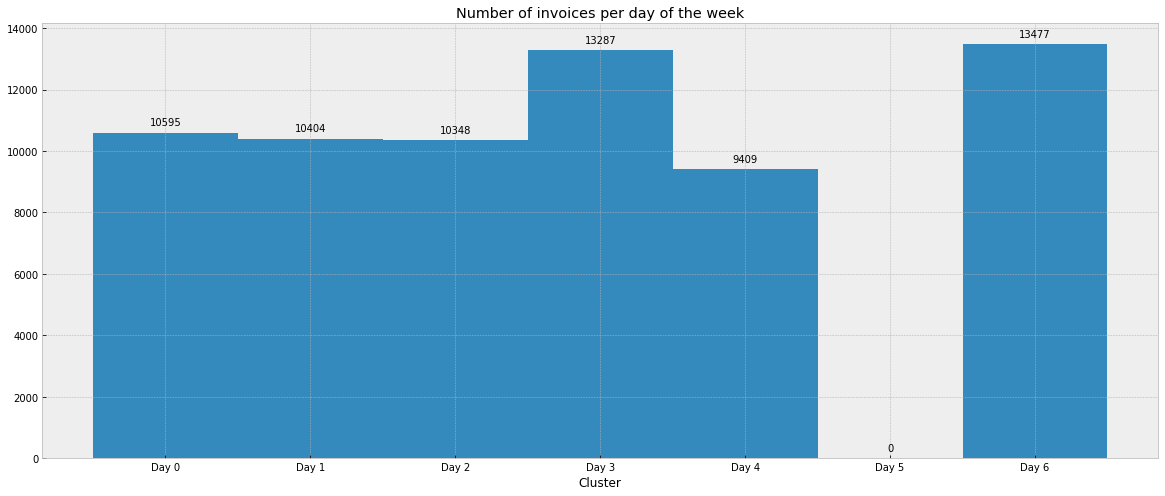

In [516]:
plt.figure(figsize = (20,8))
n, bins, patches = plt.hist(cluster5['Weekday'], bins=7)
plt.xlabel("Cluster")
plt.title("Number of invoices per day of the week")
plt.xticks([rect.get_x()+ rect.get_width() / 2 for rect in patches], ["Day {}".format(x) for x in range(0, 7)])

for rect in patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2

    space = 5
    va = 'bottom'
    label = str(int(y_value))
    
    plt.annotate(
        label,                      
        (x_value, y_value),         
        xytext=(0, space),          
        textcoords="offset points", 
        ha='center',                
        va=va)

In [517]:
cluster5['Day'].nunique()

31

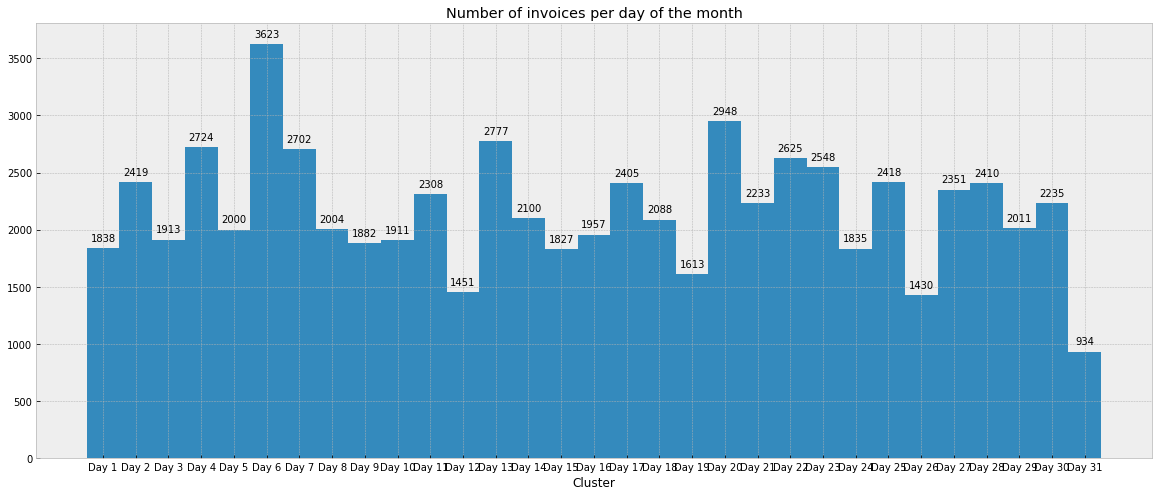

In [518]:
plt.figure(figsize = (20,8))
n, bins, patches = plt.hist(cluster5['Day'], bins=31)
plt.xlabel("Cluster")
plt.title("Number of invoices per day of the month")
plt.xticks([rect.get_x()+ rect.get_width() / 2 for rect in patches], ["Day {}".format(x) for x in range(1,32)])

for rect in patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2

    space = 5
    va = 'bottom'
    label = str(int(y_value))
    
    plt.annotate(
        label,                      
        (x_value, y_value),         
        xytext=(0, space),          
        textcoords="offset points", 
        ha='center',                
        va=va)

In [519]:
cluster5['Hour'].nunique()

15

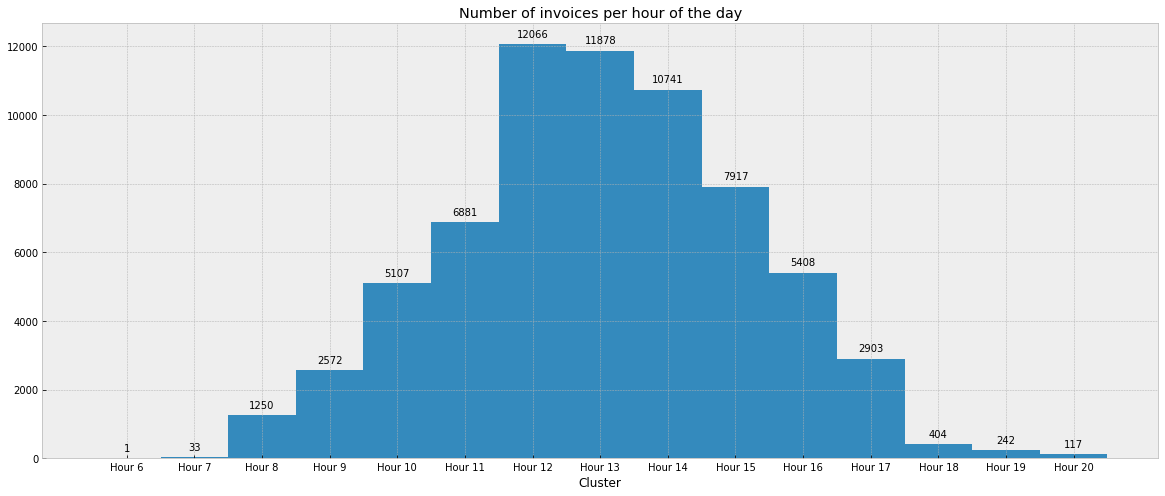

In [520]:
plt.figure(figsize = (20,8))
n, bins, patches = plt.hist(cluster5['Hour'], bins=15)
plt.xlabel("Cluster")
plt.title("Number of invoices per hour of the day")
plt.xticks([rect.get_x()+ rect.get_width() / 2 for rect in patches], ["Hour {}".format(x) for x in (sorted(cluster5['Hour'].unique()))])

for rect in patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2

    space = 5
    va = 'bottom'
    label = str(int(y_value))
    
    plt.annotate(
        label,                      
        (x_value, y_value),         
        xytext=(0, space),          
        textcoords="offset points", 
        ha='center',                
        va=va)

This cluster is very similar to the previous one. The main difference is that these customers aren't totally lost yet. So we'll just categorize them as almost lost customers. The weird part about them is that there are some months when they don't shop at all, it looks like a pattern. 



Key figures: 
* Min Basket Price: 20.83
* Mean Basket Price: 33.77
* Max Basket Price: 26.43

* Quantity:            9.06
* UnitPrice:           2.68
* QuantityCanceled:     0.02
* TotalPrice:           13.77
* Frequency            3.065758
* Recency         36.131902

TOP 10 bought products :

* PAPER CHAIN KIT 50'S CHRISTMAS:        267
* BAKING SET 9 PIECE RETROSPOT:          263
* WHITE HANGING HEART T-LIGHT HOLDER:    250
* ASSORTED COLOUR BIRD ORNAMENT:         247
* REX CASH+CARRY JUMBO SHOPPER:          223
* HOT WATER BOTTLE KEEP CALM:            215
* REGENCY CAKESTAND 3 TIER:              208
* RABBIT NIGHT LIGHT:                    200
* GARDENERS KNEELING PAD KEEP CALM:      194
* SPOTTY BUNTING:                        193

## Cluster 1

In [521]:
final_dataset[final_dataset['cluster']==1]

,min,max,mean,min_recency,max_recency,frequency,monetary_value,quantity,country,cluster,...,Cluster_125,Cluster_126,Cluster_127,Cluster_128,Cluster_129,Cluster_130,Cluster_131,Cluster_132,Cluster_133,Cluster_134
CustomerID,,,,,,,,,,,,,,,,,,,,,
12352.0,9.90,35.70,19.650000,36.0,296.0,6,1265.41,463,24,1,...,0.000000,0.000000,0.000000,0.028923,0.000000,0.039355,0.000000,0.000000,0.000000,0.0
12356.0,25.50,102.00,51.300000,22.0,325.0,3,2487.43,1573,26,1,...,0.000000,0.000000,0.012061,0.013990,0.000000,0.087198,0.012543,0.000000,0.009488,0.0
12363.0,15.90,69.36,42.630000,109.0,242.0,2,552.00,408,36,1,...,0.000000,0.054130,0.000000,0.000000,0.000000,0.179348,0.000000,0.000000,0.000000,0.0
12421.0,9.90,30.00,18.225000,15.0,319.0,4,639.04,478,30,1,...,0.000000,0.000000,0.000000,0.082812,0.000000,0.171539,0.000000,0.000000,0.000000,0.0
12433.0,10.08,60.00,28.422857,0.0,373.0,7,13375.87,11071,24,1,...,0.000000,0.006029,0.000000,0.000000,0.000000,0.038691,0.018158,0.002961,0.000000,0.0
12451.0,9.12,15.00,12.324000,10.0,324.0,5,8893.52,6454,32,1,...,0.000000,0.020766,0.001147,0.000000,0.000000,0.017136,0.038057,0.000000,0.001687,0.0
12456.0,15.00,28.08,19.660000,44.0,254.0,3,2553.89,1618,32,1,...,0.003900,0.018325,0.000000,0.033028,0.000000,0.022789,0.013438,0.000000,0.020792,0.0
12457.0,19.80,196.35,104.412500,81.0,239.0,4,1597.78,703,32,1,...,0.000000,0.041558,0.006384,0.000000,0.000000,0.008261,0.000000,0.000000,0.000000,0.0
12458.0,15.12,30.00,22.560000,71.0,284.0,2,787.40,502,32,1,...,0.025298,0.000000,0.000000,0.000000,0.020066,0.000000,0.000000,0.000000,0.000000,0.0


In [522]:
final_dataset[final_dataset['cluster']==1].mean()

min                 10.868873
max                 68.571541
mean                30.606080
min_recency         36.645725
max_recency        311.987694
frequency            6.928109
monetary_value    2576.290000
quantity          1507.218264
country             34.860104
cluster              1.000000
Cluster_0            0.001184
Cluster_1            0.009512
Cluster_2            0.005713
Cluster_3            0.001344
Cluster_4            0.003567
Cluster_5            0.000257
Cluster_6            0.012590
Cluster_7            0.000951
Cluster_8            0.007282
Cluster_9            0.000339
Cluster_10           0.002158
Cluster_11           0.020356
Cluster_12           0.009392
Cluster_13           0.003743
Cluster_14           0.011042
Cluster_15           0.013522
Cluster_16           0.021527
Cluster_17           0.006811
Cluster_18           0.010365
Cluster_19           0.001979
                     ...     
Cluster_105          0.008133
Cluster_106          0.000306
Cluster_10

In [243]:
cust1 = list(final_dataset[final_dataset['cluster']==1]['CustomerID'])


In [253]:
cluster1 = df_cleaned[df_cleaned['CustomerID'].isin(cust1)]
cluster1[['Quantity', 'UnitPrice', 'QuantityCanceled', 'TotalPrice', 'frequency', 'min_recency'
         , 'monetary_value']].mean()

Quantity              10.001698
UnitPrice              2.878234
QuantityCanceled       0.045751
TotalPrice            17.095914
frequency             11.134050
min_recency           24.574626
monetary_value      5506.056879
dtype: float64

In [245]:
cluster1['Description'].value_counts()[:11]

WHITE HANGING HEART T-LIGHT HOLDER    1345
JUMBO BAG RED RETROSPOT               1079
REGENCY CAKESTAND 3 TIER               960
ASSORTED COLOUR BIRD ORNAMENT          926
PARTY BUNTING                          924
LUNCH BAG RED RETROSPOT                898
LUNCH BAG  BLACK SKULL.                753
SET OF 3 CAKE TINS PANTRY DESIGN       725
LUNCH BAG CARS BLUE                    679
LUNCH BAG PINK POLKADOT                676
LUNCH BAG SUKI DESIGN                  672
Name: Description, dtype: int64

In [526]:
custom_aggregation = {}
custom_aggregation["Country"] = lambda x:x.iloc[0]
custom_aggregation["RFMScore"] = lambda x:x.iloc[0]

cluster1_grouped = cluster1.groupby("CustomerID").agg(custom_aggregation)

In [527]:
cluster1_grouped['RFMScore'].value_counts()

111    361
211    152
322    123
222    118
122     97
321     80
221     67
311     58
121     48
112     47
323     44
212     43
223     41
333     39
332     37
233     31
312     23
123     21
133     20
334     19
232     19
234     15
132      7
134      6
324      5
231      5
224      3
411      3
113      3
331      2
213      2
124      2
412      1
114      1
422      1
Name: RFMScore, dtype: int64

In [528]:
cluster1_grouped['Country'].value_counts()

35    1509
30      13
32       6
26       6
31       2
25       2
24       2
23       2
36       1
29       1
Name: Country, dtype: int64

In [529]:
cluster1['Month'].nunique()

12

In [530]:
cluster1['Month'].value_counts()

11    33058
12    25772
10    24572
9     22344
5     18174
3     17980
8     16670
6     15930
7     15700
4     15634
1     13889
2     12952
Name: Month, dtype: int64

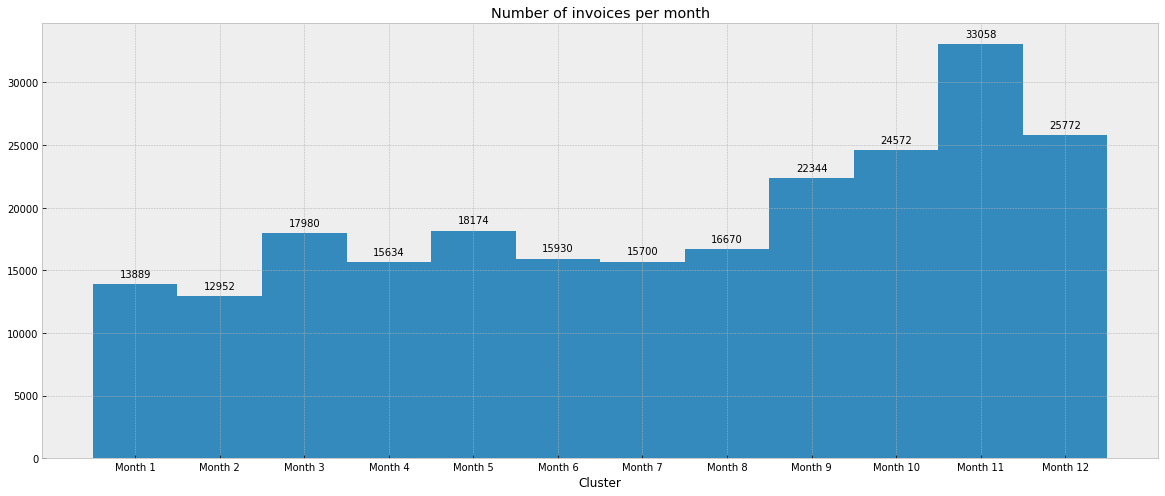

In [531]:
plt.figure(figsize = (20,8))
n, bins, patches = plt.hist(cluster1['Month'], bins=12)
plt.xlabel("Cluster")
plt.title("Number of invoices per month")
plt.xticks([rect.get_x()+ rect.get_width() / 2 for rect in patches], ["Month {}".format(x) for x in range(1, 13)])

for rect in patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2

    space = 5
    va = 'bottom'
    label = str(int(y_value))
    
    plt.annotate(
        label,                      
        (x_value, y_value),         
        xytext=(0, space),          
        textcoords="offset points", 
        ha='center',                
        va=va)

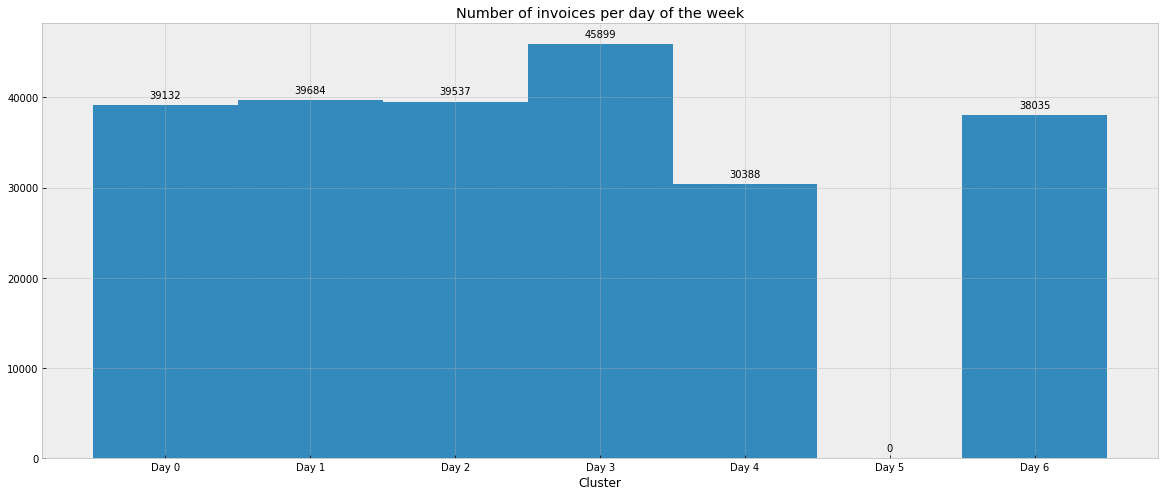

In [532]:
plt.figure(figsize = (20,8))
n, bins, patches = plt.hist(cluster1['Weekday'], bins=7)
plt.xlabel("Cluster")
plt.title("Number of invoices per day of the week")
plt.xticks([rect.get_x()+ rect.get_width() / 2 for rect in patches], ["Day {}".format(x) for x in range(0, 7)])

for rect in patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2

    space = 5
    va = 'bottom'
    label = str(int(y_value))
    
    plt.annotate(
        label,                      
        (x_value, y_value),         
        xytext=(0, space),          
        textcoords="offset points", 
        ha='center',                
        va=va)

In [533]:
cluster1['Day'].nunique()

31

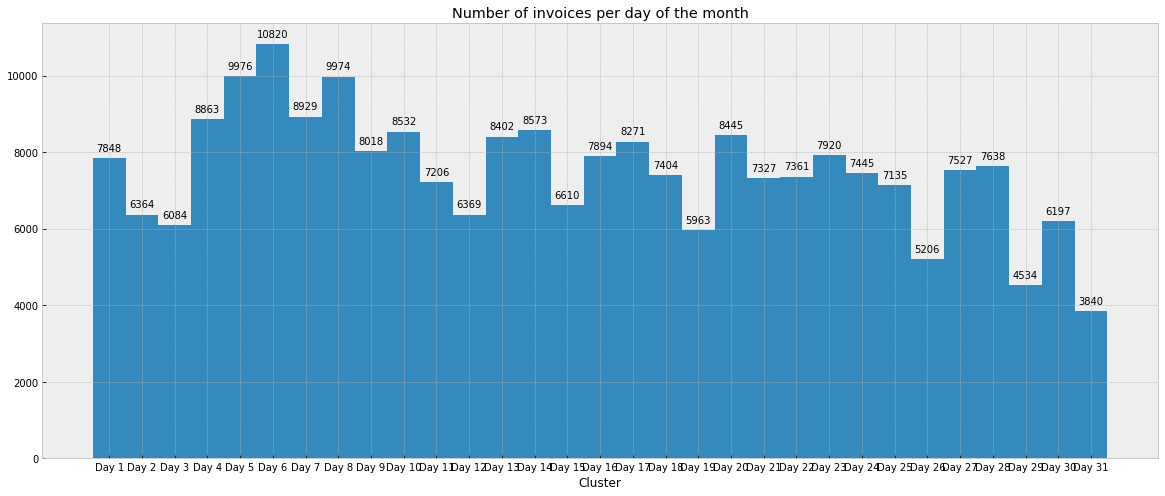

In [534]:
plt.figure(figsize = (20,8))
n, bins, patches = plt.hist(cluster1['Day'], bins=31)
plt.xlabel("Cluster")
plt.title("Number of invoices per day of the month")
plt.xticks([rect.get_x()+ rect.get_width() / 2 for rect in patches], ["Day {}".format(x) for x in range(1,32)])

for rect in patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2

    space = 5
    va = 'bottom'
    label = str(int(y_value))
    
    plt.annotate(
        label,                      
        (x_value, y_value),         
        xytext=(0, space),          
        textcoords="offset points", 
        ha='center',                
        va=va)

In [535]:
cluster1['Hour'].nunique()

14

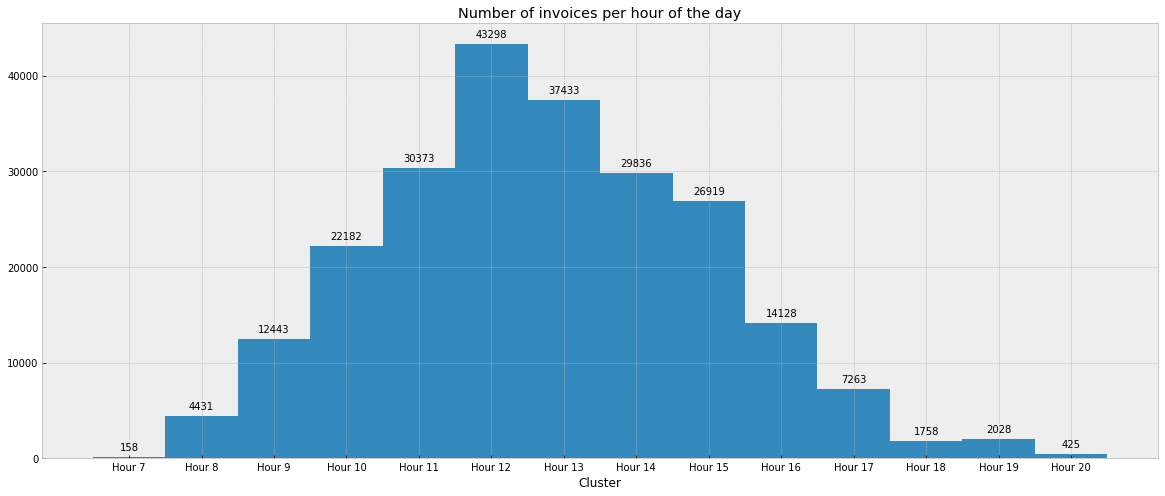

In [536]:
plt.figure(figsize = (20,8))
n, bins, patches = plt.hist(cluster1['Hour'], bins=14)
plt.xlabel("Cluster")
plt.title("Number of invoices per hour of the day")
plt.xticks([rect.get_x()+ rect.get_width() / 2 for rect in patches], ["Hour {}".format(x) for x in (sorted(cluster1['Hour'].unique()))])

for rect in patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2

    space = 5
    va = 'bottom'
    label = str(int(y_value))
    
    plt.annotate(
        label,                      
        (x_value, y_value),         
        xytext=(0, space),          
        textcoords="offset points", 
        ha='center',                
        va=va)

These customers seems to be good for datazone since they have good RFM scores, the 4 most represented categories are (111, 211, 322, 222). They seem to be normal customers. 


Key figures: 
* Min Basket Price: 10.86
* Mean Basket Price: 30.60
* Max Basket Price: 68.57

* Quantity:            10.00
* UnitPrice:           2.87
* QuantityCanceled:     0.04
* TotalPrice:           17.09
* Frequency           11.134050
* Recency         24.574626

TOP 10 bought products :

* WHITE HANGING HEART T-LIGHT HOLDER:    1345
* JUMBO BAG RED RETROSPOT:               1079
* REGENCY CAKESTAND 3 TIER:               960
* ASSORTED COLOUR BIRD ORNAMENT:          926
* PARTY BUNTING:                          924
* LUNCH BAG RED RETROSPOT:                898
* LUNCH BAG  BLACK SKULL:                753
* SET OF 3 CAKE TINS PANTRY DESIGN:       725
* LUNCH BAG CARS BLUE:                    679
* LUNCH BAG PINK POLKADOT:                676

# Conclusion

Let's quickly classify the clusters in terms of importance to Datazon :

- Cluster 2: high frequency with a lot of quantity (mean basket price of 513) bought on average and high monetary value (VIP clients)
- Cluster 7 : very high purchase frequency with a mean basket price of 150 but good monetary value.
- Cluster 6: very high basket price (huge quantity of products bought on average)
- Cluster 1: good average customers 
- Cluster 3: good foreign customers 
- Cluster 5: almost lost customers
- Cluster 4: highest monetary value but only one or two purchases over the year 
- Cluster 0: lost customers 